# Oil & Gas Production Portfolio Monte Carlo Simulation Analysis

This notebook performs a comprehensive Monte Carlo simulation and analysis of an oil and gas production portfolio. It explores various aspects of portfolio valuation, risk assessment, and optimization under uncertainty, integrating traditional financial modeling with advanced analytical techniques.

## Table of Contents

1.  **Setup & Imports**
2.  **Define Simulation Config**
3.  **Create / Load wells_master**
4.  **EDA on wells_master**
5.  **Core Model Functions**
6.  **Sensitivity Analysis Framework**
    *   Tornado Chart for Key Parameters
7.  **Price Model Comparison**
    *   Geometric Brownian Motion (GBM) vs. Mean-Reverting Model
8.  **Enhanced Scenario Visualization**
    *   P10, P50, and P90 Cash Flow Profiles
    *   Representative Price and Production Paths
9.  **Break-Even Analysis Functionality**
    *   Individual Well Break-Even Prices
    *   Portfolio Break-Even Oil Price
10. **Reinforcement Learning for Portfolio Optimization**
    *   Design of RL Environment (State, Action, Reward)
    *   Basic RL Agent Implementation and Training Loop
11. **Automated Report Generation**
12. **Key Insights and Decision-Making Implications**


#Oil & Gas Production Portfolio Monte Carlo Simulation

In [1]:
# 0. Setup & Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# optional: for nicer plots
plt.style.use("seaborn-v0_8")

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)


In [15]:
# 1. Define Simulation Config

SIM_CONFIG = {
    "n_scenarios": 1000,            # start point
    "horizon_years": 20,
    "months_per_year": 12,
    "discount_rate_annual": 0.10,   # 10%

    # Price model (GBM-style)
    "price_model": "gbm",
    "oil_mu_annual": 0.02,          # 2% drift
    "oil_sigma_annual": 0.30,       # 30% vol
    "start_price": 80.0,            # $/bbl

    # Economic limit
    "economic_limit_rate_bpd": 10.0,
}

# Derived params for convenience
SIM_CONFIG["horizon_months"] = SIM_CONFIG["horizon_years"] * SIM_CONFIG["months_per_year"]
SIM_CONFIG["dt_years"] = 1.0 / SIM_CONFIG["months_per_year"]

SIM_CONFIG


{'n_scenarios': 1000,
 'horizon_years': 20,
 'months_per_year': 12,
 'discount_rate_annual': 0.1,
 'price_model': 'gbm',
 'oil_mu_annual': 0.02,
 'oil_sigma_annual': 0.3,
 'start_price': 80.0,
 'economic_limit_rate_bpd': 10.0,
 'horizon_months': 240,
 'dt_years': 0.08333333333333333}

In [16]:
# 2. Create / Load wells_master

#

n_wells = 20
basins = ["Permian", "EagleFord", "Delaware"]
well_ids = [f"W{i:03d}" for i in range(n_wells)]

wells_master = pd.DataFrame({
    "well_id": well_ids,
    "basin": rng.choice(basins, size=n_wells),

    # initial rate (IP) in bbl/day
    "initial_rate_mean": rng.uniform(500, 1500, size=n_wells),
    "initial_rate_std":  rng.uniform(50, 200, size=n_wells),

    # decline parameters
    "decline_Di_mean": rng.uniform(0.5, 1.0, size=n_wells),   # nominal per year
    "decline_Di_std":  rng.uniform(0.05, 0.2, size=n_wells),
    "decline_b_mean":  rng.uniform(0.2, 0.9, size=n_wells),
    "decline_b_std":   rng.uniform(0.02, 0.1, size=n_wells),

    # capex (one-time) and opex (monthly)
    "capex_mean":         rng.uniform(3e6, 8e6, size=n_wells),
    "capex_std":          rng.uniform(0.2e6, 1e6, size=n_wells),

    # opex split into fixed + variable per bbl
    "opex_fixed_monthly_mean":    rng.uniform(20_000, 60_000, size=n_wells),
    "opex_fixed_monthly_std":     rng.uniform(3_000, 15_000, size=n_wells),
    "opex_variable_per_bbl_mean": rng.uniform(2.0, 6.0, size=n_wells),  # $/bbl
    "opex_variable_per_bbl_std":  rng.uniform(0.5, 2.0, size=n_wells),

    # optional: start date placeholder
    "start_date": pd.to_datetime("2015-01-01")
})

wells_master.head()


,well_id,basin,initial_rate_mean,initial_rate_std,decline_Di_mean,decline_Di_std,decline_b_mean,decline_b_std,capex_mean,capex_std,opex_fixed_monthly_mean,opex_fixed_monthly_std,opex_variable_per_bbl_mean,opex_variable_per_bbl_std,start_date
0,W000,Delaware,800.948692,174.414292,0.573087,0.056521,0.745297,0.093308,3.687040e+06,944988.988552,42119.722610,6623.128697,4.625076,1.776697,2015-01-01
1,W001,Delaware,988.584045,169.522563,0.912332,0.077225,0.294187,0.058473,7.794401e+06,295786.870801,57445.599474,14021.302746,2.144651,0.732819,2015-01-01
2,W002,Delaware,1162.864213,84.896111,0.655167,0.085512,0.575248,0.046269,7.004421e+06,293682.852720,51212.059756,12375.528425,2.021719,1.601932,2015-01-01
3,W003,EagleFord,1455.623257,129.615439,0.571936,0.087408,0.559956,0.062835,5.968410e+06,270167.209529,39174.782565,4327.060932,2.206632,0.789562,2015-01-01
4,W004,EagleFord,786.446227,140.902373,0.960485,0.135685,0.800301,0.087885,6.913121e+06,726290.628032,35054.378939,14964.415894,4.423701,0.906138,2015-01-01


In [17]:
wells_master.to_csv("wells_master.csv", index=False)


In [18]:
wells_master = pd.read_csv("wells_master.csv")


Basic describe:


,well_id,basin,initial_rate_mean,initial_rate_std,decline_Di_mean,decline_Di_std,decline_b_mean,decline_b_std,capex_mean,capex_std,opex_fixed_monthly_mean,opex_fixed_monthly_std,opex_variable_per_bbl_mean,opex_variable_per_bbl_std,start_date
count,20,20,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20
unique,20,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,W000,Delaware,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
freq,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
mean,NaN,NaN,1008.872163,128.493723,0.689602,0.122045,0.522517,0.064404,5.880375e+06,580557.690485,42542.707203,9489.935643,3.917135,1.259057,NaN
std,NaN,NaN,325.291512,38.486395,0.153318,0.050781,0.157685,0.022348,1.270253e+06,234606.856641,11460.238792,4348.424801,1.356286,0.492522,NaN
min,NaN,NaN,517.836784,59.983829,0.510574,0.056521,0.294187,0.026759,3.475246e+06,270167.209529,20492.107436,3347.994038,2.021719,0.563526,NaN
25%,NaN,NaN,749.919569,101.389688,0.572799,0.074231,0.423889,0.045465,5.428056e+06,393843.294271,37033.018547,5212.903670,2.432003,0.771398,NaN
50%,NaN,NaN,1021.891044,134.390244,0.648764,0.120501,0.480693,0.069892,5.959395e+06,520771.249427,42825.021304,10894.858510,4.471874,1.420889,NaN
75%,NaN,NaN,1289.662816,163.807247,0.806768,0.171483,0.593359,0.080181,6.928734e+06,790317.854621,51663.039929,13603.900415,5.117289,1.620479,NaN



Basin counts:
basin
Delaware     9
Permian      6
EagleFord    5
Name: count, dtype: int64


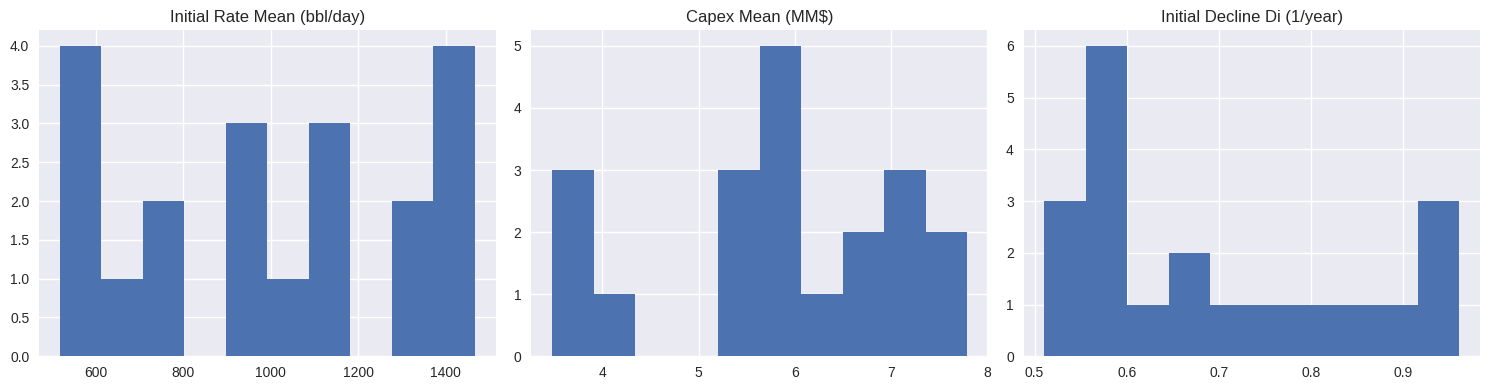

In [19]:
# 3. EDA on wells_master

print("Basic describe:")
display(wells_master.describe(include="all"))

print("\nBasin counts:")
print(wells_master["basin"].value_counts())

# histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(wells_master["initial_rate_mean"], bins=10)
axes[0].set_title("Initial Rate Mean (bbl/day)")

axes[1].hist(wells_master["capex_mean"] / 1e6, bins=10)
axes[1].set_title("Capex Mean (MM$)")

axes[2].hist(wells_master["decline_Di_mean"], bins=10)
axes[2].set_title("Initial Decline Di (1/year)")

plt.tight_layout()
plt.show()


In [20]:
# 4. Core Model Functions

def hyperbolic_rate(q0, Di, b, t_years):
    """
    Hyperbolic decline curve (Arps).

    q(t) = q0 / (1 + b * Di * t)^(1/b)

    Parameters
    ----------
    q0 : float
        Initial rate (e.g. bbl/day).
    Di : float
        Initial nominal decline rate (1/year).
    b : float
        Hyperbolic exponent (dimensionless).
    t_years : np.ndarray
        Time in years (same units as Di).
    """
    return q0 / np.power(1.0 + b * Di * t_years, 1.0 / b)


def generate_price_path_gbm(
    start_price: float,
    mu_annual: float,
    sigma_annual: float,
    n_months: int,
    dt_years: float,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Generate a monthly price path using a simple GBM discretization.
    """
    prices = np.empty(n_months)
    prices[0] = start_price

    mu = mu_annual
    sigma = sigma_annual

    for m in range(1, n_months):
        z = rng.normal()
        drift = (mu - 0.5 * sigma**2) * dt_years
        shock = sigma * np.sqrt(dt_years) * z
        prices[m] = prices[m-1] * np.exp(drift + shock)

    return prices


def compute_npv_from_monthly_cashflows(
    cashflows: np.ndarray,
    discount_rate_annual: float
) -> float:
    """
    Compute NPV from a vector of monthly cashflows.
    """
    n_months = len(cashflows)
    r_month = (1.0 + discount_rate_annual)**(1.0 / 12.0) - 1.0
    month_indices = np.arange(n_months)
    discount_factors = 1.0 / np.power(1.0 + r_month, month_indices)
    return float(np.sum(cashflows * discount_factors))


def sample_well_parameters(well_row: pd.Series, rng: np.random.Generator):
    """
    Sample uncertain well parameters from normal distributions,
    with simple lower/upper clamps for sanity.
    """
    q0 = rng.normal(well_row["initial_rate_mean"], well_row["initial_rate_std"])
    Di = rng.normal(well_row["decline_Di_mean"], well_row["decline_Di_std"])
    b  = rng.normal(well_row["decline_b_mean"],  well_row["decline_b_std"])

    capex = rng.normal(well_row["capex_mean"], well_row["capex_std"])

    opex_fixed = rng.normal(
        well_row["opex_fixed_monthly_mean"],
        well_row["opex_fixed_monthly_std"]
    )
    opex_variable = rng.normal(
        well_row["opex_variable_per_bbl_mean"],
        well_row["opex_variable_per_bbl_std"]
    )

    # Sanity clamps (no negatives)
    q0 = max(q0, 1.0)
    Di = max(Di, 0.01)
    b  = max(min(b, 1.5), 0.05)
    capex = max(capex, 0.0)
    opex_fixed = max(opex_fixed, 0.0)
    opex_variable = max(opex_variable, 0.0)

    return q0, Di, b, capex, opex_fixed, opex_variable


In [22]:
# 4.1 Simple sanity tests for core functions

def test_decline_curve_monotonic():
    q0, Di, b = 1000.0, 0.8, 0.6
    t_years = np.linspace(0, 10, 200)
    q = hyperbolic_rate(q0, Di, b, t_years)
    # ensure non-increasing
    assert np.all(np.diff(q) <= 1e-6), "Decline curve is not monotonic decreasing."
    print("test_decline_curve_monotonic passed.")

def test_npv_zero_cf():
    cf = np.zeros(240)
    npv = compute_npv_from_monthly_cashflows(cf, 0.10)
    assert abs(npv) < 1e-6, "NPV of zero cashflows should be zero."
    print("test_npv_zero_cf passed.")

test_decline_curve_monotonic()
test_npv_zero_cf()


test_decline_curve_monotonic passed.
test_npv_zero_cf passed.


In [23]:
# 5. Single Scenario Simulation (with economic limit + per-basin CF)

def simulate_portfolio_single_scenario(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng: np.random.Generator
):
    """
    Simulate one scenario:
    - Generate one price path
    - For each well, sample parameters, simulate cashflows with economic limit
    - Aggregate portfolio cashflows
    - Track per-basin cashflows
    - Compute NPV for portfolio and each basin
    """
    n_months = sim_config["horizon_months"]
    dt_years = sim_config["dt_years"]
    months_per_year = sim_config["months_per_year"]
    econ_rate_threshold = sim_config["economic_limit_rate_bpd"]

    # 1) Price path for this scenario
    prices = generate_price_path_gbm(
        start_price=sim_config["start_price"],
        mu_annual=sim_config["oil_mu_annual"],
        sigma_annual=sim_config["oil_sigma_annual"],
        n_months=n_months,
        dt_years=dt_years,
        rng=rng
    )

    # 2) Initialize portfolio and basin cashflows
    portfolio_cf = np.zeros(n_months, dtype=float)
    basins = wells_master["basin"].unique()
    basin_cf = {b: np.zeros(n_months, dtype=float) for b in basins}

    # Time grid
    month_indices = np.arange(n_months)
    t_years = month_indices / months_per_year
    days_per_month = 30.0

    # 3) Loop over wells
    for _, well in wells_master.iterrows():
        q0, Di, b, capex, opex_fixed, opex_var = sample_well_parameters(well, rng)

        # decline curve
        rate_bpd = hyperbolic_rate(q0, Di, b, t_years)
        volume_monthly = rate_bpd * days_per_month  # bbl/month

        # economic limit: shut-in when rate < threshold
        below_limit = rate_bpd < econ_rate_threshold
        if np.any(below_limit):
            shut_idx = np.argmax(below_limit)  # first index where True
            # zero out future production and volume
            rate_bpd[shut_idx+1:] = 0.0
            volume_monthly[shut_idx+1:] = 0.0

        revenue_monthly = volume_monthly * prices

        # Opex = fixed + variable * volume
        opex = opex_fixed + opex_var * volume_monthly

        # Capex: allocate all in month 0 for now
        capex_vec = np.zeros(n_months)
        capex_vec[0] = capex

        cashflow_well = revenue_monthly - opex - capex_vec

        portfolio_cf += cashflow_well
        basin_cf[well["basin"]] += cashflow_well

    # 4) NPVs
    portfolio_npv = compute_npv_from_monthly_cashflows(
        portfolio_cf, sim_config["discount_rate_annual"]
    )

    basin_npv = {
        b: compute_npv_from_monthly_cashflows(cf, sim_config["discount_rate_annual"])
        for b, cf in basin_cf.items()
    }

    return portfolio_cf, portfolio_npv, basin_npv, prices


In [24]:
# 6. Monte Carlo Engine (Many Scenarios, with per-basin NPV)

def run_monte_carlo(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng_seed: int
):
    """
    Run Monte Carlo over n_scenarios:
    - For each scenario, simulate portfolio + basin NPVs
    - Return:
        scenario_results : scenario_id -> portfolio_npv
        basin_results    : (scenario_id, basin) -> basin_npv
    """
    n_scenarios = sim_config["n_scenarios"]
    rng = np.random.default_rng(rng_seed)

    npvs = np.empty(n_scenarios, dtype=float)
    basin_records = []

    for s in range(n_scenarios):
        portfolio_cf, portfolio_npv, basin_npv, prices = simulate_portfolio_single_scenario(
            wells_master, sim_config, rng
        )
        npvs[s] = portfolio_npv

        for basin, npv_b in basin_npv.items():
            basin_records.append({
                "scenario_id": s,
                "basin": basin,
                "basin_npv": npv_b
            })

        if (s + 1) % max(1, n_scenarios // 10) == 0:
            print(f"Completed scenario {s+1}/{n_scenarios}")

    scenario_results = pd.DataFrame({
        "scenario_id": np.arange(n_scenarios),
        "portfolio_npv": npvs
    })

    basin_results = pd.DataFrame(basin_records)

    return scenario_results, basin_results

scenario_results, basin_results = run_monte_carlo(wells_master, SIM_CONFIG, RNG_SEED)
scenario_results.head()


Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000


,scenario_id,portfolio_npv
0,0,6.899130e+08
1,1,1.032729e+09
2,2,8.273489e+08
3,3,1.326640e+09
4,4,8.596671e+08


Mean NPV: 981,524,717
Std NPV:  463,632,058
P10 NPV:  515,070,321
P50 NPV:  877,108,052
P90 NPV:  1,564,212,274
VaR 5% (NPV): 435,372,127
CVaR 5%:      378,900,673


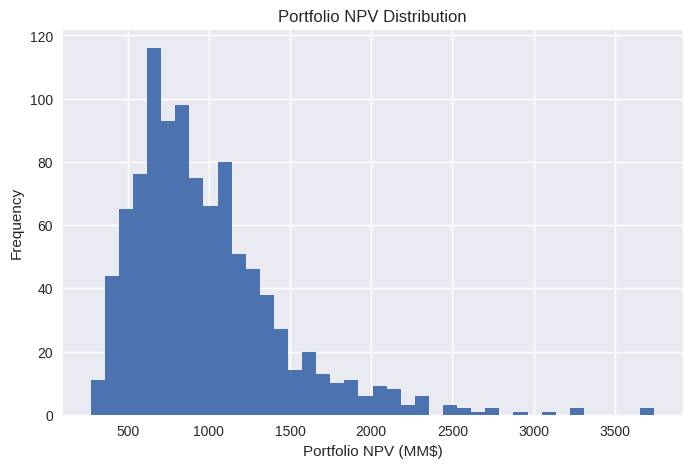

In [25]:
# 7. Risk Metrics & Plots (Portfolio-level)

npvs = scenario_results["portfolio_npv"].values

mean_npv = np.mean(npvs)
std_npv = np.std(npvs)

p10, p50, p90 = np.percentile(npvs, [10, 50, 90])

# CVaR at 5% (downside)
alpha = 5
var_5 = np.percentile(npvs, alpha)
cvar_5 = np.mean(npvs[npvs <= var_5])

print(f"Mean NPV: {mean_npv:,.0f}")
print(f"Std NPV:  {std_npv:,.0f}")
print(f"P10 NPV:  {p10:,.0f}")
print(f"P50 NPV:  {p50:,.0f}")
print(f"P90 NPV:  {p90:,.0f}")
print(f"VaR 5% (NPV): {var_5:,.0f}")
print(f"CVaR 5%:      {cvar_5:,.0f}")

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(npvs / 1e6, bins=40)
plt.xlabel("Portfolio NPV (MM$)")
plt.ylabel("Frequency")
plt.title("Portfolio NPV Distribution")
plt.show()


In [26]:
# 7.1 Basin-level risk metrics

# Compute mean and P10/P50/P90 per basin
def basin_risk_summary(basin_results: pd.DataFrame):
    stats = []
    for basin, grp in basin_results.groupby("basin"):
        vals = grp["basin_npv"].values
        mean_npv = np.mean(vals)
        p10, p50, p90 = np.percentile(vals, [10, 50, 90])
        stats.append({
            "basin": basin,
            "mean_npv": mean_npv,
            "p10_npv": p10,
            "p50_npv": p50,
            "p90_npv": p90
        })
    return pd.DataFrame(stats)

basin_summary = basin_risk_summary(basin_results)
basin_summary


,basin,mean_npv,p10_npv,p50_npv,p90_npv
0,Delaware,4.381167e+08,2.193464e+08,3.921810e+08,7.141024e+08
1,EagleFord,2.523301e+08,1.356142e+08,2.275062e+08,4.062690e+08
2,Permian,2.910779e+08,1.512040e+08,2.614592e+08,4.711116e+08


In [27]:
# 7.2 Compare basin NPVs vs portfolio NPVs (simple correlation)

merged = basin_results.merge(scenario_results, on="scenario_id", how="inner")

corrs = (
    merged
    .groupby("basin")
    .apply(lambda g: np.corrcoef(g["basin_npv"], g["portfolio_npv"])[0, 1])
    .reset_index()
)
corrs.columns = ["basin", "corr_basin_portfolio"]
corrs


/tmp/ipython-input-769495270.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.corrcoef(g["basin_npv"], g["portfolio_npv"])[0, 1])


,basin,corr_basin_portfolio
0,Delaware,0.982346
1,EagleFord,0.968152
2,Permian,0.966454


In [28]:
# 7.3 Outlier analysis: worst and best scenarios

n_scenarios = SIM_CONFIG["n_scenarios"]

k = max(1, n_scenarios // 20)  # worst 5%, best 5% as an example

worst = scenario_results.nsmallest(k, "portfolio_npv")
best  = scenario_results.nlargest(k, "portfolio_npv")

print("Worst scenarios (5%):")
display(worst)

print("Best scenarios (5%):")
display(best)


Worst scenarios (5%):


,scenario_id,portfolio_npv
134,134,2.724186e+08
36,36,2.726143e+08
980,980,2.933142e+08
133,133,2.956795e+08
936,936,3.039933e+08
508,508,3.111047e+08
785,785,3.250668e+08
575,575,3.312224e+08
104,104,3.331812e+08
216,216,3.396991e+08


Best scenarios (5%):


,scenario_id,portfolio_npv
754,754,3.743705e+09
340,340,3.669634e+09
32,32,3.242446e+09
50,50,3.235957e+09
685,685,3.068708e+09
101,101,2.959658e+09
161,161,2.763212e+09
55,55,2.730569e+09
748,748,2.643683e+09
750,750,2.551407e+09


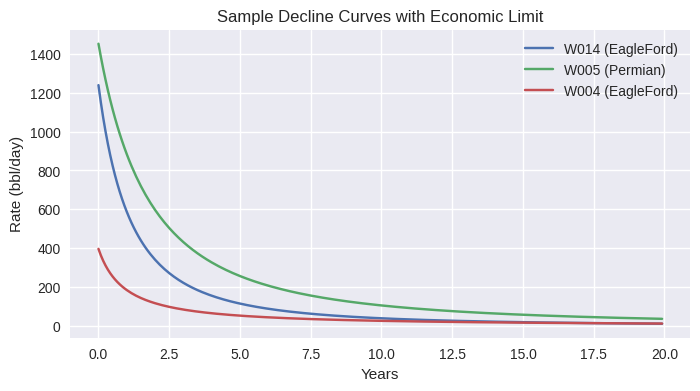

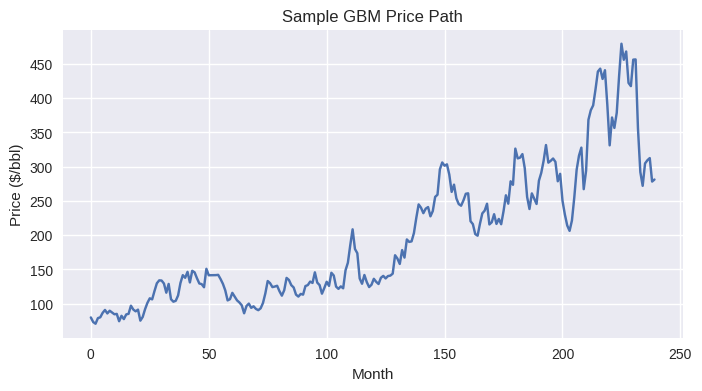

In [29]:
# 8. Optional: visualize a single scenario's decline curves & price path
# (Re-run one scenario in isolation for illustration)

def simulate_single_scenario_diagnostics(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng_seed: int
):
    rng_local = np.random.default_rng(rng_seed)
    n_months = sim_config["horizon_months"]
    dt_years = sim_config["dt_years"]
    months_per_year = sim_config["months_per_year"]
    econ_rate_threshold = sim_config["economic_limit_rate_bpd"]

    prices = generate_price_path_gbm(
        start_price=sim_config["start_price"],
        mu_annual=sim_config["oil_mu_annual"],
        sigma_annual=sim_config["oil_sigma_annual"],
        n_months=n_months,
        dt_years=dt_years,
        rng=rng_local
    )

    month_indices = np.arange(n_months)
    t_years = month_indices / months_per_year
    days_per_month = 30.0

    # pick a small subset of wells to plot
    sample_wells = wells_master.sample(min(3, len(wells_master)), random_state=123)

    plt.figure(figsize=(8, 4))
    for _, well in sample_wells.iterrows():
        q0, Di, b, capex, opex_fixed, opex_var = sample_well_parameters(well, rng_local)
        rate_bpd = hyperbolic_rate(q0, Di, b, t_years)

        below_limit = rate_bpd < econ_rate_threshold
        if np.any(below_limit):
            shut_idx = np.argmax(below_limit)
            rate_bpd[shut_idx+1:] = 0.0

        plt.plot(t_years, rate_bpd, label=f"{well['well_id']} ({well['basin']})")

    plt.xlabel("Years")
    plt.ylabel("Rate (bbl/day)")
    plt.title("Sample Decline Curves with Economic Limit")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(month_indices, prices)
    plt.xlabel("Month")
    plt.ylabel("Price ($/bbl)")
    plt.title("Sample GBM Price Path")
    plt.show()

simulate_single_scenario_diagnostics(wells_master, SIM_CONFIG, rng_seed=123)


# Task
Perform a comprehensive analysis of an oil and gas production portfolio using Monte Carlo simulation. This includes: developing a sensitivity analysis framework with a Tornado Chart for key parameters (initial rate, decline rate, oil price volatility); implementing and comparing a mean-reverting price model against the current GBM model, analyzing their impact on NPV and risk metrics; plotting P10, P50, and P90 cash flow profiles; visualizing representative price and production paths; developing break-even analysis functionality for wells and the portfolio; designing and implementing a Reinforcement Learning environment and agent for portfolio optimization; and finally, automating the generation of a structured report summarizing all findings, including risk metrics, sensitivity analysis, price model comparisons, break-even analysis, and RL agent insights, with all generated plots. Conclude by reviewing all analyses and summarizing key insights for decision-making.

## Develop Sensitivity Analysis Framework

### Subtask:
Create a function to systematically vary key input parameters (initial rate, decline rate, oil price volatility) one at a time across a defined range and record the impact on the portfolio's Net Present Value (NPV).


**Reasoning**:
The first step in developing the sensitivity analysis framework is to define the perturbation percentage and calculate the baseline mean portfolio NPV from the existing Monte Carlo simulation results. This will serve as a reference point for comparing the impact of parameter variations.



In [30]:
perturbation_percentage = 0.10 # 10% perturbation
baseline_mean_npv = scenario_results["portfolio_npv"].mean()

print(f"Perturbation Percentage: {perturbation_percentage*100:.0f}%")
print(f"Baseline Mean Portfolio NPV: {baseline_mean_npv:,.0f}")


Perturbation Percentage: 10%
Baseline Mean Portfolio NPV: 981,524,717


**Reasoning**:
The next step is to create the `run_sensitivity_analysis` function as instructed. This function will systematically vary key input parameters by a defined perturbation percentage, run Monte Carlo simulations for each variation, and record the impact on the portfolio's mean NPV. This will require copying the `wells_master` DataFrame and `SIM_CONFIG` dictionary to ensure changes are temporary and do not affect subsequent parameter variations.



In [31]:
import copy

def run_sensitivity_analysis(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng_seed: int,
    perturbation_percentage: float
):
    """
    Runs a sensitivity analysis by varying key parameters one at a time
    and recording the impact on the mean portfolio NPV.
    """
    sensitivity_results = []

    # Parameters to vary and their original source (DataFrame or Dict)
    parameters_to_vary = [
        {'name': 'initial_rate_mean', 'source': 'wells_master'},
        {'name': 'decline_Di_mean', 'source': 'wells_master'},
        {'name': 'oil_sigma_annual', 'source': 'sim_config'},
    ]

    # Run a baseline Monte Carlo simulation to get the reference NPV for comparison
    baseline_scenario_results, _ = run_monte_carlo(wells_master, sim_config, rng_seed)
    baseline_mean_npv = baseline_scenario_results["portfolio_npv"].mean()

    for param_info in parameters_to_vary:
        param_name = param_info['name']
        param_source = param_info['source']

        print(f"\nRunning sensitivity for: {param_name}")

        # Store original states before perturbation
        original_wells_master = wells_master.copy()
        original_sim_config = copy.deepcopy(sim_config)

        # --- Perturb LOW value ---
        temp_wells_master_low = original_wells_master.copy()
        temp_sim_config_low = copy.deepcopy(original_sim_config)

        if param_source == 'wells_master':
            temp_wells_master_low[param_name] = temp_wells_master_low[param_name] * (1 - perturbation_percentage)
        elif param_source == 'sim_config':
            temp_sim_config_low[param_name] = temp_sim_config_low[param_name] * (1 - perturbation_percentage)

        scenario_results_low, _ = run_monte_carlo(temp_wells_master_low, temp_sim_config_low, rng_seed)
        mean_npv_low = scenario_results_low["portfolio_npv"].mean()

        # --- Perturb HIGH value ---
        temp_wells_master_high = original_wells_master.copy()
        temp_sim_config_high = copy.deepcopy(original_sim_config)

        if param_source == 'wells_master':
            temp_wells_master_high[param_name] = temp_wells_master_high[param_name] * (1 + perturbation_percentage)
        elif param_source == 'sim_config':
            temp_sim_config_high[param_name] = temp_sim_config_high[param_name] * (1 + perturbation_percentage)

        scenario_results_high, _ = run_monte_carlo(temp_wells_master_high, temp_sim_config_high, rng_seed)
        mean_npv_high = scenario_results_high["portfolio_npv"].mean()

        sensitivity_results.append({
            'parameter': param_name,
            'low_npv_mean': mean_npv_low,
            'high_npv_mean': mean_npv_high
        })

    # Add baseline to results for context
    return baseline_mean_npv, sensitivity_results

# Run the sensitivity analysis
baseline_npv, sensitivity_analysis_results = run_sensitivity_analysis(
    wells_master, SIM_CONFIG, RNG_SEED, perturbation_percentage
)

print(f"\nBaseline Mean Portfolio NPV: {baseline_npv:,.0f}")
print("\nSensitivity Analysis Results:")
for res in sensitivity_analysis_results:
    print(f"  Parameter: {res['parameter']}")
    print(f"    Mean NPV (Low): {res['low_npv_mean']:,.0f}")
    print(f"    Mean NPV (High): {res['high_npv_mean']:,.0f}")


Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000

Running sensitivity for: initial_rate_mean
Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000
Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000

Running sensitivity for: decline_Di_mean
Completed scenario 100/1000
Completed scenario 200/1000
Completed scena

## Generate Tornado Chart for Sensitivity Analysis

### Subtask:
Visualize the results from the sensitivity analysis using a Tornado Chart. This chart will graphically represent the range of NPV outcomes caused by varying each input parameter, making it easy to identify the most impactful drivers of portfolio value. Ensure the chart is clearly labeled with legends.


**Reasoning**:
The first step is to prepare the data for the Tornado chart by calculating the change in NPV for both low and high perturbations relative to the baseline mean NPV. This also involves calculating the total impact of each parameter and storing these values in a structured format for plotting.



In [32]:
tornado_data = []
for res in sensitivity_analysis_results:
    param = res['parameter']
    low_npv_mean = res['low_npv_mean']
    high_npv_mean = res['high_npv_mean']

    # Calculate change from baseline
    change_low = low_npv_mean - baseline_mean_npv
    change_high = high_npv_mean - baseline_mean_npv

    # Calculate total impact for sorting
    total_impact = high_npv_mean - low_npv_mean

    tornado_data.append({
        'parameter': param,
        'change_low': change_low,
        'change_high': change_high,
        'total_impact': total_impact
    })

# Sort by total impact in descending order
tornado_data_sorted = sorted(tornado_data, key=lambda x: abs(x['total_impact']), reverse=True)

# Extract data for plotting
params = [d['parameter'] for d in tornado_data_sorted]
changes_low = [d['change_low'] / 1e6 for d in tornado_data_sorted] # Convert to MM$
changes_high = [d['change_high'] / 1e6 for d in tornado_data_sorted] # Convert to MM$

print("Prepared Tornado Chart Data:")
for d in tornado_data_sorted:
    print(f"  Parameter: {d['parameter']}, Change Low: {d['change_low']/1e6:.2f} MM$, Change High: {d['change_high']/1e6:.2f} MM$, Total Impact: {d['total_impact']/1e6:.2f} MM$")

Prepared Tornado Chart Data:
  Parameter: initial_rate_mean, Change Low: -119.31 MM$, Change High: 119.26 MM$, Total Impact: 238.57 MM$
  Parameter: decline_Di_mean, Change Low: 100.03 MM$, Change High: -84.24 MM$, Total Impact: -184.27 MM$
  Parameter: oil_sigma_annual, Change Low: 0.72 MM$, Change High: -0.84 MM$, Total Impact: -1.56 MM$


**Reasoning**:
Now that the data is prepared and sorted, I will create a Tornado Chart using `matplotlib.pyplot` to visualize the sensitivity of the portfolio NPV to changes in key parameters. This involves plotting horizontal bars representing the low and high perturbation impacts relative to the baseline, adding appropriate labels, title, and a vertical line at zero.



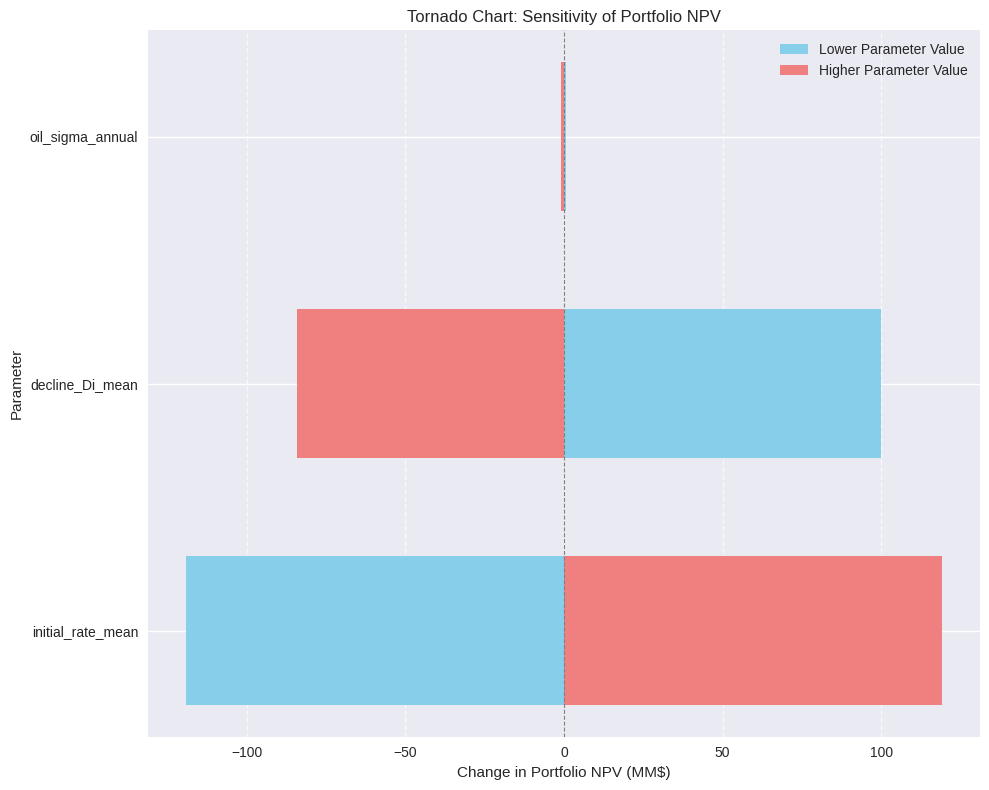

In [33]:
plt.figure(figsize=(10, 8))

y_pos = np.arange(len(params))

# Plot bars for negative deviations (left side of baseline)
plt.barh(y_pos, changes_low, color='skyblue', label='Lower Parameter Value', height=0.6)
# Plot bars for positive deviations (right side of baseline)
plt.barh(y_pos, changes_high, color='lightcoral', label='Higher Parameter Value', height=0.6)

# Add a vertical line at 0 for the baseline NPV
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.yticks(y_pos, params)
plt.xlabel('Change in Portfolio NPV (MM$)')
plt.ylabel('Parameter')
plt.title('Tornado Chart: Sensitivity of Portfolio NPV')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Implement Mean-Reverting Price Model

### Subtask:
Develop a new function for generating oil price paths based on a mean-reverting stochastic process (e.g., Ornstein-Uhlenbeck or Vasicek model). This will serve as an alternative to the current Geometric Brownian Motion (GBM) model, potentially offering a more realistic representation for commodity prices.


**Reasoning**:
I need to define the new mean-reverting price model parameters (`reversion_speed`, `long_term_mean_price`, `mr_sigma_annual`) within the `SIM_CONFIG` dictionary as instructed. This sets up the configuration for the new price model.



In [34]:
SIM_CONFIG["reversion_speed"] = 0.5
SIM_CONFIG["long_term_mean_price"] = 70.0
SIM_CONFIG["mr_sigma_annual"] = 0.20

print("Updated SIM_CONFIG with Mean-Reverting Price Model parameters:")
print(SIM_CONFIG)


Updated SIM_CONFIG with Mean-Reverting Price Model parameters:
{'n_scenarios': 1000, 'horizon_years': 20, 'months_per_year': 12, 'discount_rate_annual': 0.1, 'price_model': 'gbm', 'oil_mu_annual': 0.02, 'oil_sigma_annual': 0.3, 'start_price': 80.0, 'economic_limit_rate_bpd': 10.0, 'horizon_months': 240, 'dt_years': 0.08333333333333333, 'reversion_speed': 0.5, 'long_term_mean_price': 70.0, 'mr_sigma_annual': 0.2}


**Reasoning**:
Now that the parameters are defined in `SIM_CONFIG`, I will create the `generate_price_path_mean_reverting` function, implementing the Euler-Maruyama discretization for the Ornstein-Uhlenbeck process to generate monthly price paths as instructed. This function will also ensure prices remain non-negative.



In [35]:
def generate_price_path_mean_reverting(
    start_price: float,
    reversion_speed: float,      # kappa
    long_term_mean_price: float, # theta
    mr_sigma_annual: float,      # sigma
    n_months: int,
    dt_years: float,
    rng: np.random.Generator
) -> np.ndarray:
    """
    Generate a monthly price path using the Ornstein-Uhlenbeck (mean-reverting) process.
    Euler-Maruyama discretization.
    """
    prices = np.empty(n_months)
    prices[0] = start_price

    # Convert annual sigma to monthly for dt_years
    # The dt_years is already 1/12 for monthly steps in terms of years

    # Euler-Maruyama discretization:
    # P(t+dt) = P(t) + kappa * (theta - P(t)) * dt + sigma_mr * sqrt(dt) * dW
    # where dt is in years (1/12 in our case)

    for m in range(1, n_months):
        current_price = prices[m-1]
        drift = reversion_speed * (long_term_mean_price - current_price) * dt_years
        # dW is standard normal (mean 0, std 1)
        shock = mr_sigma_annual * np.sqrt(dt_years) * rng.normal()
        prices[m] = current_price + drift + shock

        # Ensure prices are non-negative
        prices[m] = max(prices[m], 1e-6) # Clamp at a very small positive number

    return prices

print("Defined generate_price_path_mean_reverting function.")

Defined generate_price_path_mean_reverting function.


**Reasoning**:
To fully implement the mean-reverting price model, I need to modify the `simulate_portfolio_single_scenario` function to use `generate_price_path_mean_reverting` when `SIM_CONFIG['price_model']` is set to 'mean_reverting', otherwise it should continue to use `generate_price_path_gbm`.



In [36]:
def simulate_portfolio_single_scenario( # Re-define the function
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng: np.random.Generator
):
    """
    Simulate one scenario:
    - Generate one price path (either GBM or Mean-Reverting)
    - For each well, sample parameters, simulate cashflows with economic limit
    - Aggregate portfolio cashflows
    - Track per-basin cashflows
    - Compute NPV for portfolio and each basin
    """
    n_months = sim_config["horizon_months"]
    dt_years = sim_config["dt_years"]
    months_per_year = sim_config["months_per_year"]
    econ_rate_threshold = sim_config["economic_limit_rate_bpd"]

    # 1) Price path for this scenario
    if sim_config["price_model"] == "gbm":
        prices = generate_price_path_gbm(
            start_price=sim_config["start_price"],
            mu_annual=sim_config["oil_mu_annual"],
            sigma_annual=sim_config["oil_sigma_annual"],
            n_months=n_months,
            dt_years=dt_years,
            rng=rng
        )
    elif sim_config["price_model"] == "mean_reverting":
        prices = generate_price_path_mean_reverting(
            start_price=sim_config["start_price"],
            reversion_speed=sim_config["reversion_speed"],
            long_term_mean_price=sim_config["long_term_mean_price"],
            mr_sigma_annual=sim_config["mr_sigma_annual"],
            n_months=n_months,
            dt_years=dt_years,
            rng=rng
        )
    else:
        raise ValueError("Unsupported price model: " + sim_config["price_model"])

    # 2) Initialize portfolio and basin cashflows
    portfolio_cf = np.zeros(n_months, dtype=float)
    basins = wells_master["basin"].unique()
    basin_cf = {b: np.zeros(n_months, dtype=float) for b in basins}

    # Time grid
    month_indices = np.arange(n_months)
    t_years = month_indices / months_per_year
    days_per_month = 30.0

    # 3) Loop over wells
    for _, well in wells_master.iterrows():
        q0, Di, b, capex, opex_fixed, opex_var = sample_well_parameters(well, rng)

        # decline curve
        rate_bpd = hyperbolic_rate(q0, Di, b, t_years)
        volume_monthly = rate_bpd * days_per_month  # bbl/month

        # economic limit: shut-in when rate < threshold
        below_limit = rate_bpd < econ_rate_threshold
        if np.any(below_limit):
            shut_idx = np.argmax(below_limit)  # first index where True
            # zero out future production and volume
            rate_bpd[shut_idx+1:] = 0.0
            volume_monthly[shut_idx+1:] = 0.0

        revenue_monthly = volume_monthly * prices

        # Opex = fixed + variable * volume
        opex = opex_fixed + opex_var * volume_monthly

        # Capex: allocate all in month 0 for now
        capex_vec = np.zeros(n_months)
        capex_vec[0] = capex

        cashflow_well = revenue_monthly - opex - capex_vec

        portfolio_cf += cashflow_well
        basin_cf[well["basin"]] += cashflow_well

    # 4) NPVs
    portfolio_npv = compute_npv_from_monthly_cashflows(
        portfolio_cf, sim_config["discount_rate_annual"]
    )

    basin_npv = {
        b: compute_npv_from_monthly_cashflows(cf, sim_config["discount_rate_annual"])
        for b, cf in basin_cf.items()
    }

    return portfolio_cf, portfolio_npv, basin_npv, prices

print("simulate_portfolio_single_scenario function updated to support mean-reverting price model.")


simulate_portfolio_single_scenario function updated to support mean-reverting price model.


## Compare Price Model Impacts

### Subtask:
Run Monte Carlo simulations using both the GBM and mean-reverting price models, then analyze and visualize their impact on portfolio NPV and risk metrics.


**Reasoning**:
The first step is to configure the simulation to use the Geometric Brownian Motion (GBM) price model by setting `SIM_CONFIG['price_model']` to 'gbm'. Then, I will run the Monte Carlo simulation with this configuration and store the results.



In [37]:
import copy

# Make a deep copy of SIM_CONFIG to avoid modifying the original config for sensitivity analysis
sim_config_gbm = copy.deepcopy(SIM_CONFIG)
sim_config_gbm["price_model"] = "gbm"

print(f"Running Monte Carlo with Price Model: {sim_config_gbm['price_model']}")
gbm_scenario_results, _ = run_monte_carlo(wells_master, sim_config_gbm, RNG_SEED)

gbm_scenario_results.head()

Running Monte Carlo with Price Model: gbm
Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000


,scenario_id,portfolio_npv
0,0,6.899130e+08
1,1,1.032729e+09
2,2,8.273489e+08
3,3,1.326640e+09
4,4,8.596671e+08


**Reasoning**:
Now that the Monte Carlo simulation for the GBM model is complete, I will configure the simulation to use the mean-reverting price model by setting `SIM_CONFIG['price_model']` to 'mean_reverting'. Then, I will run the Monte Carlo simulation with this configuration and store the results in `mr_scenario_results`.



In [38]:
sim_config_mr = copy.deepcopy(SIM_CONFIG)
sim_config_mr["price_model"] = "mean_reverting"

print(f"\nRunning Monte Carlo with Price Model: {sim_config_mr['price_model']}")
mr_scenario_results, _ = run_monte_carlo(wells_master, sim_config_mr, RNG_SEED)

mr_scenario_results.head()


Running Monte Carlo with Price Model: mean_reverting
Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000


,scenario_id,portfolio_npv
0,0,7.000479e+08
1,1,9.142366e+08
2,2,8.978061e+08
3,3,7.666318e+08
4,4,9.621779e+08


**Reasoning**:
I will define a helper function to calculate the mean NPV, standard deviation of NPV, P10, P50, P90 percentiles, VaR 5%, and CVaR 5% for a given array of NPVs. Then, I will apply this function to both the GBM and mean-reverting scenario results and print the metrics, clearly labeling them by price model. This addresses the fifth instruction of the subtask.



In [39]:
def calculate_npv_metrics(npvs, model_name):
    mean_npv = np.mean(npvs)
    std_npv = np.std(npvs)
    p10, p50, p90 = np.percentile(npvs, [10, 50, 90])

    # VaR at 5%
    var_5 = np.percentile(npvs, 5)
    # CVaR at 5% (downside)
    cvar_5 = np.mean(npvs[npvs <= var_5])

    print(f"\n--- {model_name} Price Model Metrics ---")
    print(f"Mean NPV: {mean_npv:,.0f}")
    print(f"Std NPV:  {std_npv:,.0f}")
    print(f"P10 NPV:  {p10:,.0f}")
    print(f"P50 NPV:  {p50:,.0f}")
    print(f"P90 NPV:  {p90:,.0f}")
    print(f"VaR 5% (NPV): {var_5:,.0f}")
    print(f"CVaR 5%:      {cvar_5:,.0f}")

# Calculate and print metrics for GBM model
calculate_npv_metrics(gbm_scenario_results["portfolio_npv"].values, "GBM")

# Calculate and print metrics for Mean-Reverting model
calculate_npv_metrics(mr_scenario_results["portfolio_npv"].values, "Mean-Reverting")


--- GBM Price Model Metrics ---
Mean NPV: 981,524,717
Std NPV:  463,632,058
P10 NPV:  515,070,321
P50 NPV:  877,108,052
P90 NPV:  1,564,212,274
VaR 5% (NPV): 435,372,127
CVaR 5%:      378,900,673

--- Mean-Reverting Price Model Metrics ---
Mean NPV: 836,176,889
Std NPV:  55,594,718
P10 NPV:  769,713,903
P50 NPV:  831,583,713
P90 NPV:  908,231,963
VaR 5% (NPV): 754,283,155
CVaR 5%:      734,404,186


**Reasoning**:
To visualize the impact of different price models, I will create a single figure with two subplots side-by-side. Each subplot will display a histogram of the portfolio NPVs (converted to MM$) for one of the price models, with appropriate titles, labels, and legends, addressing the sixth instruction of the subtask.



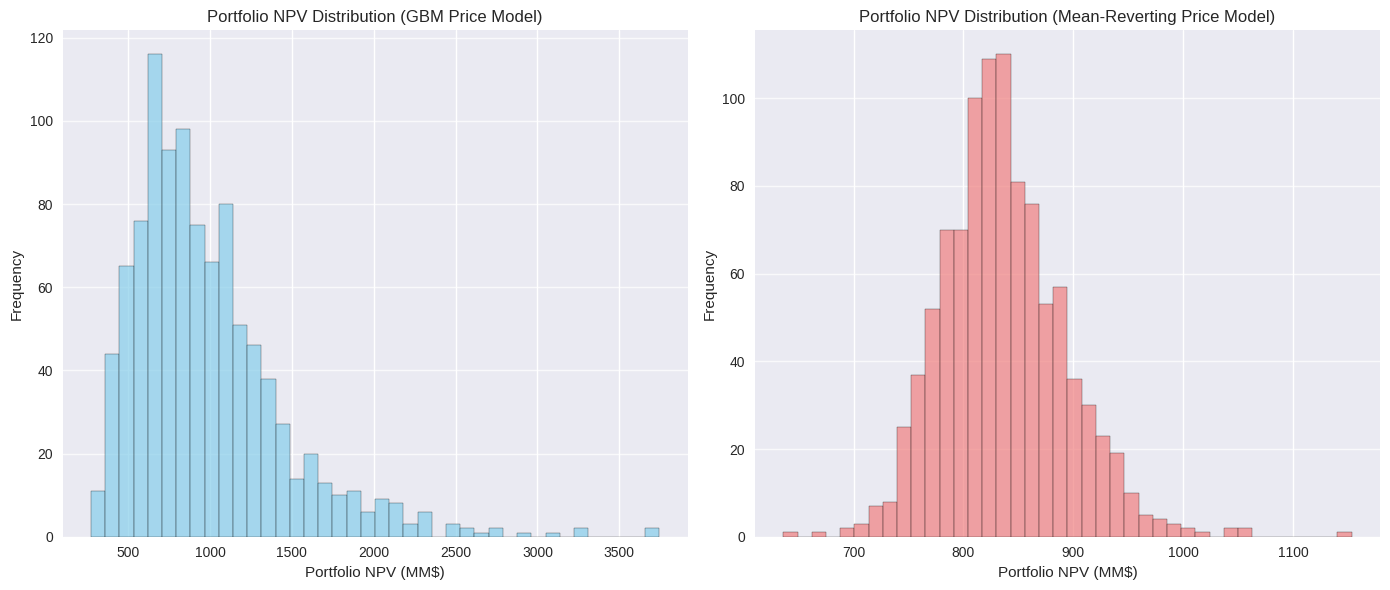

In [40]:
plt.figure(figsize=(14, 6))

# Histogram for GBM model
plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
plt.hist(gbm_scenario_results["portfolio_npv"].values / 1e6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Portfolio NPV (MM$)")
plt.ylabel("Frequency")
plt.title("Portfolio NPV Distribution (GBM Price Model)")
plt.grid(axis='y', alpha=0.75)

# Histogram for Mean-Reverting model
plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
plt.hist(mr_scenario_results["portfolio_npv"].values / 1e6, bins=40, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel("Portfolio NPV (MM$)")
plt.ylabel("Frequency")
plt.title("Portfolio NPV Distribution (Mean-Reverting Price Model)")
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

## Plot P10, P50, and P90 Cash Flow Profiles

### Subtask:
Calculate and plot the aggregated monthly cash flow profiles corresponding to the 10th, 50th (median), and 90th percentiles of the portfolio's NPV distribution.


**Reasoning**:
The first step is to redefine the `run_monte_carlo` function. This revised function will ensure each scenario uses a unique random number generator seed and will also collect and return all monthly portfolio cash flow profiles (`all_cashflows_array`) in addition to the existing `scenario_results` and `basin_results`.



In [41]:
def run_monte_carlo(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng_seed: int
):
    """
    Run Monte Carlo over n_scenarios:
    - For each scenario, simulate portfolio + basin NPVs
    - Return:
        scenario_results : scenario_id -> portfolio_npv
        basin_results    : (scenario_id, basin) -> basin_npv
        all_cashflows_array: NumPy array of all portfolio cash flow profiles (n_scenarios x n_months)
    """
    n_scenarios = sim_config["n_scenarios"]

    npvs = np.empty(n_scenarios, dtype=float)
    basin_records = []
    all_cashflows = [] # List to store monthly cash flow arrays for each scenario

    for s in range(n_scenarios):
        # Use a unique seed for each scenario
        scenario_rng = np.random.default_rng(rng_seed + s)

        portfolio_cf, portfolio_npv, basin_npv, prices = simulate_portfolio_single_scenario(
            wells_master, sim_config, scenario_rng
        )
        npvs[s] = portfolio_npv
        all_cashflows.append(portfolio_cf) # Store the cash flow profile

        for basin, npv_b in basin_npv.items():
            basin_records.append({
                "scenario_id": s,
                "basin": basin,
                "basin_npv": npv_b
            })

        if (s + 1) % max(1, n_scenarios // 10) == 0:
            print(f"Completed scenario {s+1}/{n_scenarios}")

    scenario_results = pd.DataFrame({
        "scenario_id": np.arange(n_scenarios),
        "portfolio_npv": npvs
    })

    basin_results = pd.DataFrame(basin_records)
    all_cashflows_array = np.array(all_cashflows)

    return scenario_results, basin_results, all_cashflows_array

print("run_monte_carlo function redefined to return all cash flow profiles and use unique RNG seeds per scenario.")


run_monte_carlo function redefined to return all cash flow profiles and use unique RNG seeds per scenario.


**Reasoning**:
Now that the `run_monte_carlo` function has been redefined to return `all_cashflows_array` and use unique RNG seeds per scenario, I need to re-run the Monte Carlo simulation for the GBM price model. This will generate the necessary cash flow data for percentile analysis.



In [42]:
import copy

# Make a deep copy of SIM_CONFIG to avoid modifying the original config for sensitivity analysis
sim_config_gbm = copy.deepcopy(SIM_CONFIG)
sim_config_gbm["price_model"] = "gbm"

print(f"Running Monte Carlo with Price Model: {sim_config_gbm['price_model']} (re-run to collect cashflows)")
gbm_scenario_results, gbm_basin_results, gbm_all_cashflows = run_monte_carlo(wells_master, sim_config_gbm, RNG_SEED)

gbm_scenario_results.head()


Running Monte Carlo with Price Model: gbm (re-run to collect cashflows)
Completed scenario 100/1000
Completed scenario 200/1000
Completed scenario 300/1000
Completed scenario 400/1000
Completed scenario 500/1000
Completed scenario 600/1000
Completed scenario 700/1000
Completed scenario 800/1000
Completed scenario 900/1000
Completed scenario 1000/1000


,scenario_id,portfolio_npv
0,0,6.899130e+08
1,1,5.536822e+08
2,2,1.634454e+09
3,3,5.782626e+08
4,4,8.681035e+08


**Reasoning**:
Now that the Monte Carlo simulation with the GBM model has been re-run and cash flow data is available, I will calculate the 10th, 50th (median), and 90th percentiles of the `portfolio_npv` from the `gbm_scenario_results`. These values are crucial for identifying representative scenarios for cash flow plotting.



In [43]:
npvs_gbm = gbm_scenario_results["portfolio_npv"].values

p10_npv = np.percentile(npvs_gbm, 10)
p50_npv = np.percentile(npvs_gbm, 50)
p90_npv = np.percentile(npvs_gbm, 90)

print(f"P10 NPV (GBM): {p10_npv:,.0f}")
print(f"P50 NPV (GBM): {p50_npv:,.0f}")
print(f"P90 NPV (GBM): {p90_npv:,.0f}")

P10 NPV (GBM): 540,025,133
P50 NPV (GBM): 913,975,298
P90 NPV (GBM): 1,634,456,636


**Reasoning**:
Now I will find the `scenario_id` for the scenarios whose `portfolio_npv` is closest to the calculated P10, P50, and P90 NPV percentile values. This is essential to extract the representative cash flow profiles for plotting.



In [44]:
def find_closest_scenario_id(target_npv, scenario_results):
    """
    Finds the scenario_id whose portfolio_npv is closest to the target_npv.
    """
    scenario_results['abs_diff'] = np.abs(scenario_results['portfolio_npv'] - target_npv)
    closest_scenario_id = scenario_results.loc[scenario_results['abs_diff'].idxmin()]['scenario_id']
    scenario_results.drop(columns=['abs_diff'], inplace=True) # Clean up temporary column
    return int(closest_scenario_id)

# Find scenario IDs for P10, P50, P90
p10_scenario_id = find_closest_scenario_id(p10_npv, gbm_scenario_results.copy())
p50_scenario_id = find_closest_scenario_id(p50_npv, gbm_scenario_results.copy())
p90_scenario_id = find_closest_scenario_id(p90_npv, gbm_scenario_results.copy())

print(f"Scenario ID closest to P10 NPV: {p10_scenario_id}")
print(f"Scenario ID closest to P50 NPV: {p50_scenario_id}")
print(f"Scenario ID closest to P90 NPV: {p90_scenario_id}")

Scenario ID closest to P10 NPV: 175
Scenario ID closest to P50 NPV: 150
Scenario ID closest to P90 NPV: 2


**Reasoning**:
Now that the scenario IDs for P10, P50, and P90 NPVs have been identified, I will extract their corresponding cash flow profiles from the `gbm_all_cashflows` array. This prepares the data for plotting the cash flow profiles.



In [45]:
p10_cashflow = gbm_all_cashflows[p10_scenario_id]
p50_cashflow = gbm_all_cashflows[p50_scenario_id]
p90_cashflow = gbm_all_cashflows[p90_scenario_id]

print("Extracted P10, P50, and P90 cash flow profiles.")

Extracted P10, P50, and P90 cash flow profiles.


**Reasoning**:
Now I will create a single plot showing the P10, P50, and P90 cash flow profiles over the simulation horizon, as instructed. This involves using the extracted cash flow data and `matplotlib` to visualize the different percentile outcomes.



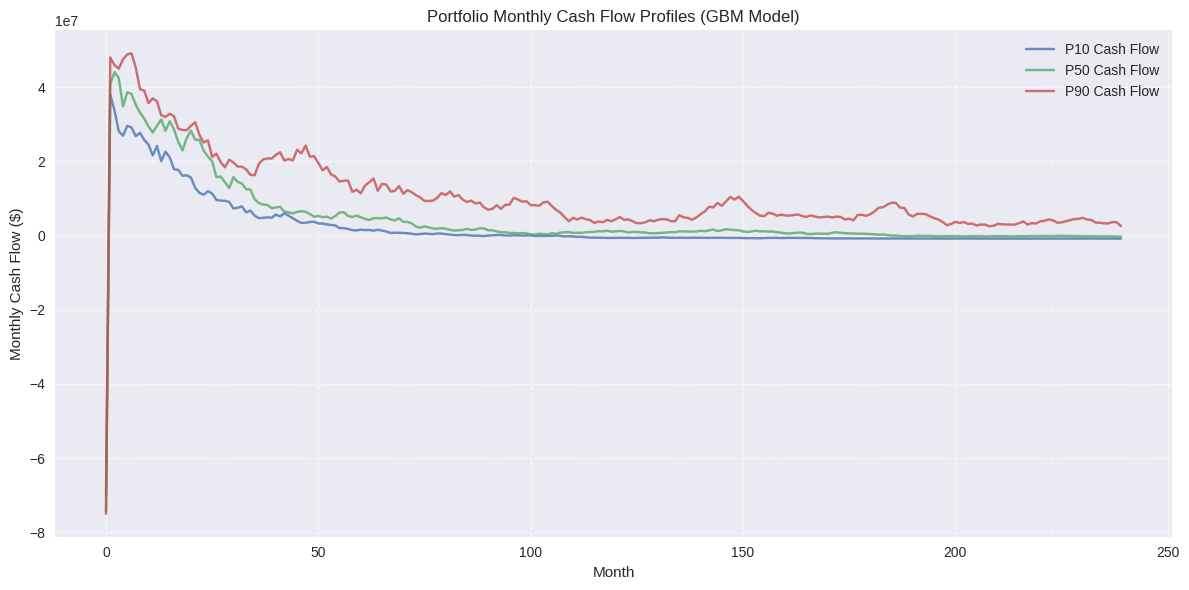

In [46]:
plt.figure(figsize=(12, 6))

months = np.arange(SIM_CONFIG["horizon_months"])

plt.plot(months, p10_cashflow, label='P10 Cash Flow', alpha=0.8)
plt.plot(months, p50_cashflow, label='P50 Cash Flow', alpha=0.8)
plt.plot(months, p90_cashflow, label='P90 Cash Flow', alpha=0.8)

plt.xlabel('Month')
plt.ylabel('Monthly Cash Flow ($)')
plt.title('Portfolio Monthly Cash Flow Profiles (GBM Model)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Visualize Multiple Scenario Price and Production Paths

### Subtask:
Select a few representative scenarios (e.g., one 'best case', one 'worst case', and one 'average case' based on portfolio NPV) from the Monte Carlo results. For each selected scenario, plot its specific oil price path and the corresponding total portfolio production rate over time to illustrate the variability of outcomes. Include legends for clarity.


**Reasoning**:
The first step is to redefine the `simulate_portfolio_single_scenario` function to return the total aggregated portfolio production rate (`portfolio_production_rate_bpd`) in addition to its existing outputs. This aggregated rate will be calculated by summing up the individual well production rates after applying the economic limit.



In [47]:
def simulate_portfolio_single_scenario(
    wells_master: pd.DataFrame,
    sim_config: dict,
    rng: np.random.Generator
):
    """
    Simulate one scenario:
    - Generate one price path (either GBM or Mean-Reverting)
    - For each well, sample parameters, simulate cashflows with economic limit
    - Aggregate portfolio cashflows
    - Track per-basin cashflows
    - Compute NPV for portfolio and each basin
    - Returns portfolio cashflows, NPV, basin NPVs, prices, and *portfolio production rates*.
    """
    n_months = sim_config["horizon_months"]
    dt_years = sim_config["dt_years"]
    months_per_year = sim_config["months_per_year"]
    econ_rate_threshold = sim_config["economic_limit_rate_bpd"]

    # 1) Price path for this scenario
    if sim_config["price_model"] == "gbm":
        prices = generate_price_path_gbm(
            start_price=sim_config["start_price"],
            mu_annual=sim_config["oil_mu_annual"],
            sigma_annual=sim_config["oil_sigma_annual"],
            n_months=n_months,
            dt_years=dt_years,
            rng=rng
        )
    elif sim_config["price_model"] == "mean_reverting":
        prices = generate_price_path_mean_reverting(
            start_price=sim_config["start_price"],
            reversion_speed=sim_config["reversion_speed"],
            long_term_mean_price=sim_config["long_term_mean_price"],
            mr_sigma_annual=sim_config["mr_sigma_annual"],
            n_months=n_months,
            dt_years=dt_years,
            rng=rng
        )
    else:
        raise ValueError("Unsupported price model: " + sim_config["price_model"])

    # 2) Initialize portfolio and basin cashflows and production rates
    portfolio_cf = np.zeros(n_months, dtype=float)
    portfolio_production_rate_bpd = np.zeros(n_months, dtype=float) # New: aggregated production

    basins = wells_master["basin"].unique()
    basin_cf = {b: np.zeros(n_months, dtype=float) for b in basins}

    # Time grid
    month_indices = np.arange(n_months)
    t_years = month_indices / months_per_year
    days_per_month = 30.0

    # 3) Loop over wells
    for _, well in wells_master.iterrows():
        q0, Di, b, capex, opex_fixed, opex_var = sample_well_parameters(well, rng)

        # decline curve
        rate_bpd = hyperbolic_rate(q0, Di, b, t_years)

        # economic limit: shut-in when rate < threshold
        below_limit = rate_bpd < econ_rate_threshold
        if np.any(below_limit):
            shut_idx = np.argmax(below_limit)  # first index where True
            # zero out future production
            rate_bpd[shut_idx+1:] = 0.0

        volume_monthly = rate_bpd * days_per_month  # bbl/month

        revenue_monthly = volume_monthly * prices

        # Opex = fixed + variable * volume
        opex = opex_fixed + opex_var * volume_monthly

        # Capex: allocate all in month 0 for now
        capex_vec = np.zeros(n_months)
        capex_vec[0] = capex

        cashflow_well = revenue_monthly - opex - capex_vec

        portfolio_cf += cashflow_well
        portfolio_production_rate_bpd += rate_bpd # Aggregate production
        basin_cf[well["basin"]] += cashflow_well

    # 4) NPVs
    portfolio_npv = compute_npv_from_monthly_cashflows(
        portfolio_cf, sim_config["discount_rate_annual"]
    )

    basin_npv = {
        b: compute_npv_from_monthly_cashflows(cf, sim_config["discount_rate_annual"])
        for b, cf in basin_cf.items()
    }

    return portfolio_cf, portfolio_npv, basin_npv, prices, portfolio_production_rate_bpd

print("simulate_portfolio_single_scenario function updated to return portfolio_production_rate_bpd.")

simulate_portfolio_single_scenario function updated to return portfolio_production_rate_bpd.


**Reasoning**:
Now that the `simulate_portfolio_single_scenario` function is updated, I need to identify the scenario IDs for the best, worst, and average cases based on the `portfolio_npv` from the `gbm_scenario_results` DataFrame. This involves finding the min, max, and closest to mean NPVs.



In [48]:
npvs_gbm = gbm_scenario_results["portfolio_npv"].values

# Best case: highest NPV
best_npv_scenario_id = gbm_scenario_results.loc[npvs_gbm.argmax(), 'scenario_id']

# Worst case: lowest NPV
worst_npv_scenario_id = gbm_scenario_results.loc[npvs_gbm.argmin(), 'scenario_id']

# Average case: closest to mean NPV
mean_npv_gbm = np.mean(npvs_gbm)
average_npv_scenario_id = find_closest_scenario_id(mean_npv_gbm, gbm_scenario_results.copy())

print(f"Best Case Scenario ID: {best_npv_scenario_id}")
print(f"Worst Case Scenario ID: {worst_npv_scenario_id}")
print(f"Average Case Scenario ID (closest to mean): {average_npv_scenario_id}")

Best Case Scenario ID: 578
Worst Case Scenario ID: 83
Average Case Scenario ID (closest to mean): 28


**Reasoning**:
Now that the scenario IDs for the best, worst, and average cases are identified, I will call the updated `simulate_portfolio_single_scenario` function for each of these scenarios. This will retrieve their specific oil price paths and aggregated portfolio production rates, using a unique random number generator seed for reproducibility.



In [49]:
scenario_data = {}

# Best case
print(f"Simulating best case scenario (ID: {best_npv_scenario_id})...")
rng_best = np.random.default_rng(RNG_SEED + best_npv_scenario_id)
_, _, _, prices_best, prod_best = simulate_portfolio_single_scenario(
    wells_master, sim_config_gbm, rng_best
)
scenario_data['best'] = {'prices': prices_best, 'production': prod_best}

# Worst case
print(f"Simulating worst case scenario (ID: {worst_npv_scenario_id})...")
rng_worst = np.random.default_rng(RNG_SEED + worst_npv_scenario_id)
_, _, _, prices_worst, prod_worst = simulate_portfolio_single_scenario(
    wells_master, sim_config_gbm, rng_worst
)
scenario_data['worst'] = {'prices': prices_worst, 'production': prod_worst}

# Average case
print(f"Simulating average case scenario (ID: {average_npv_scenario_id})...")
rng_average = np.random.default_rng(RNG_SEED + average_npv_scenario_id)
_, _, _, prices_average, prod_average = simulate_portfolio_single_scenario(
    wells_master, sim_config_gbm, rng_average
)
scenario_data['average'] = {'prices': prices_average, 'production': prod_average}

print("Price paths and production rates for representative scenarios extracted.")

Simulating best case scenario (ID: 578)...
Simulating worst case scenario (ID: 83)...
Simulating average case scenario (ID: 28)...
Price paths and production rates for representative scenarios extracted.


**Reasoning**:
Now that the price paths and production rates for the best, worst, and average scenarios have been extracted, I will create a figure with multiple subplots to visualize these paths. Each scenario will have a dedicated subplot for its oil price path and another for its total portfolio production rate over time, complete with appropriate titles, labels, and legends.



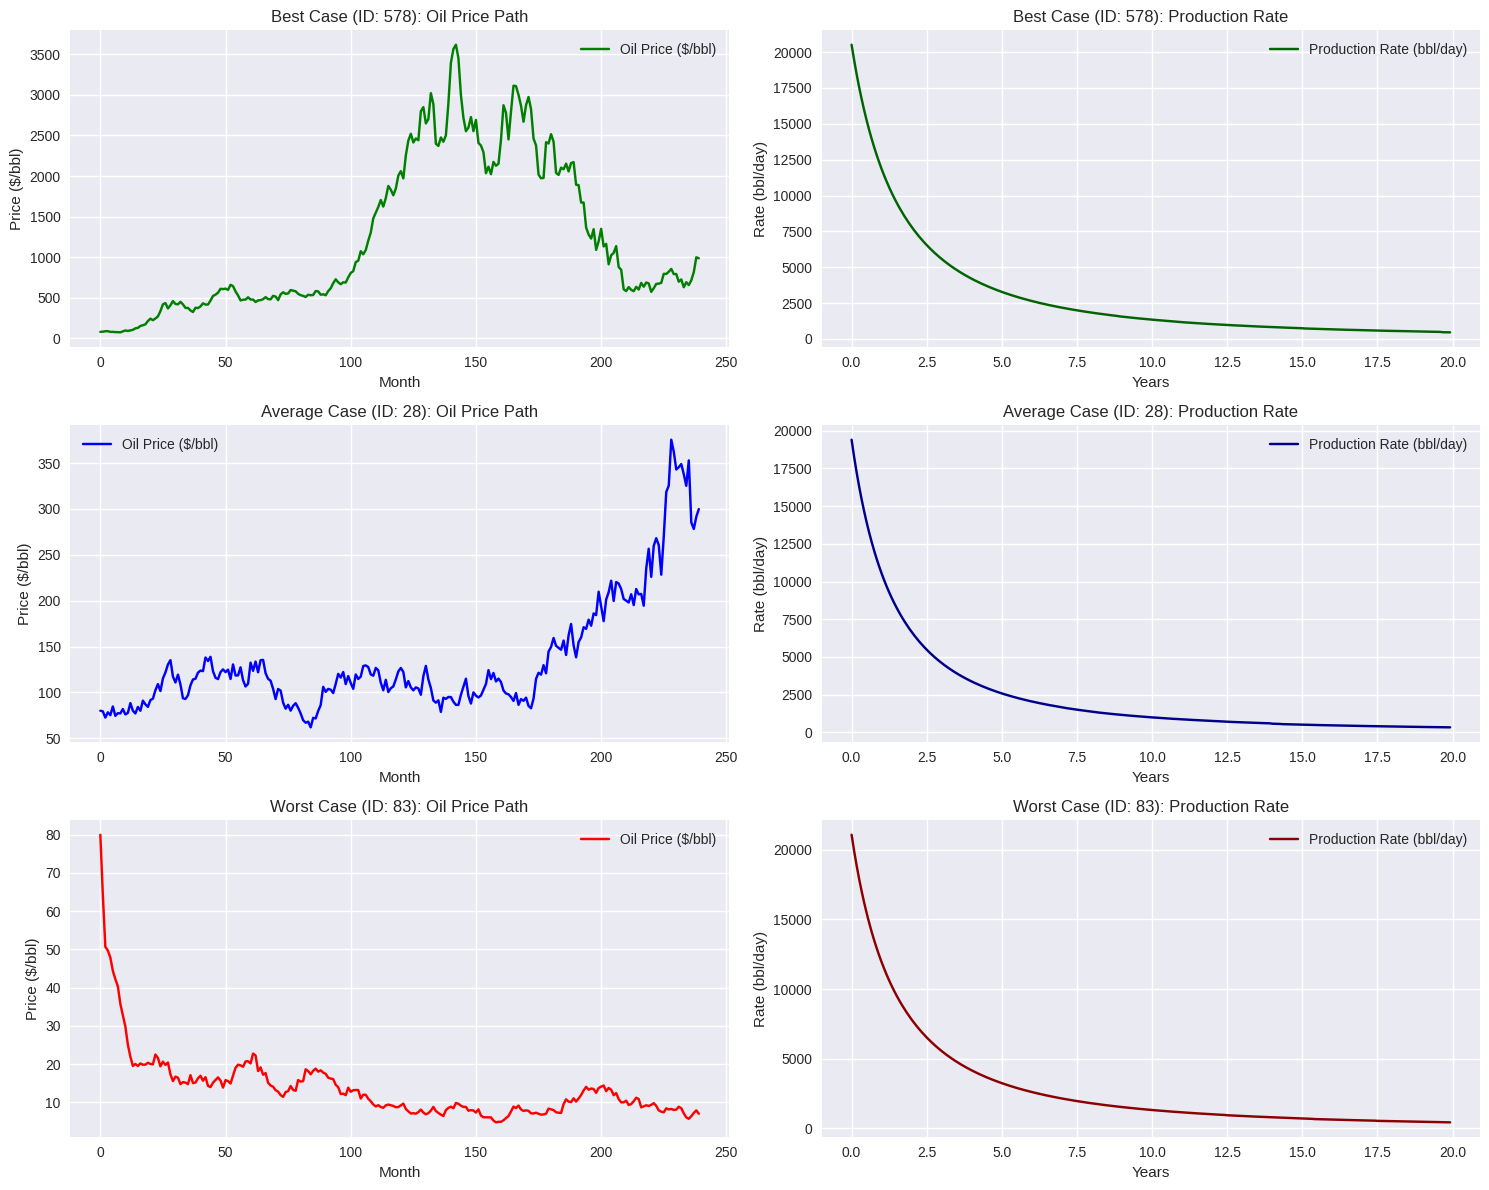

In [50]:
plt.figure(figsize=(15, 12))

month_indices = np.arange(SIM_CONFIG["horizon_months"])
t_years = month_indices / SIM_CONFIG["months_per_year"]

# Best Case
plt.subplot(3, 2, 1) # 3 rows, 2 columns, 1st subplot
plt.plot(month_indices, scenario_data['best']['prices'], label='Oil Price ($/bbl)', color='green')
plt.title(f'Best Case (ID: {best_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2) # 3 rows, 2 columns, 2nd subplot
plt.plot(t_years, scenario_data['best']['production'], label='Production Rate (bbl/day)', color='darkgreen')
plt.title(f'Best Case (ID: {best_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

# Average Case
plt.subplot(3, 2, 3) # 3 rows, 2 columns, 3rd subplot
plt.plot(month_indices, scenario_data['average']['prices'], label='Oil Price ($/bbl)', color='blue')
plt.title(f'Average Case (ID: {average_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4) # 3 rows, 2 columns, 4th subplot
plt.plot(t_years, scenario_data['average']['production'], label='Production Rate (bbl/day)', color='darkblue')
plt.title(f'Average Case (ID: {average_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

# Worst Case
plt.subplot(3, 2, 5) # 3 rows, 2 columns, 5th subplot
plt.plot(month_indices, scenario_data['worst']['prices'], label='Oil Price ($/bbl)', color='red')
plt.title(f'Worst Case (ID: {worst_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6) # 3 rows, 2 columns, 6th subplot
plt.plot(t_years, scenario_data['worst']['production'], label='Production Rate (bbl/day)', color='darkred')
plt.title(f'Worst Case (ID: {worst_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Develop Break-Even Analysis Functionality

### Subtask:
Create a function to calculate the Net Present Value (NPV) for a single well given its specific parameters and a constant oil price. This will be a foundational step for subsequent break-even analysis calculations.


**Reasoning**:
I need to define the `compute_well_npv` function as instructed. This function will calculate the NPV for a single well under a constant oil price, incorporating well decline, economic limits, and all relevant costs (capex, fixed opex, variable opex).



In [51]:
def compute_well_npv(well: pd.Series, constant_oil_price: float, sim_config: dict):
    """
    Calculate the NPV for a single well given its specific parameters and a constant oil price.
    """
    n_months = sim_config["horizon_months"]
    months_per_year = sim_config["months_per_year"]
    dt_years = sim_config["dt_years"]
    econ_rate_threshold = sim_config["economic_limit_rate_bpd"]

    # Use mean parameters for a deterministic calculation
    # (No random sampling for this specific function)
    q0 = well["initial_rate_mean"]
    Di = well["decline_Di_mean"]
    b  = well["decline_b_mean"]
    capex = well["capex_mean"]
    opex_fixed = well["opex_fixed_monthly_mean"]
    opex_variable = well["opex_variable_per_bbl_mean"]

    # Time grid
    month_indices = np.arange(n_months)
    t_years = month_indices / months_per_year
    days_per_month = 30.0

    # Decline curve
    rate_bpd = hyperbolic_rate(q0, Di, b, t_years)

    # Economic limit: shut-in when rate < threshold
    below_limit = rate_bpd < econ_rate_threshold
    if np.any(below_limit):
        shut_idx = np.argmax(below_limit)  # first index where True
        rate_bpd[shut_idx+1:] = 0.0

    volume_monthly = rate_bpd * days_per_month  # bbl/month

    # Revenue based on constant oil price
    revenue_monthly = volume_monthly * constant_oil_price

    # Opex = fixed + variable * volume
    opex = opex_fixed + opex_variable * volume_monthly

    # Capex: allocate all in month 0
    capex_vec = np.zeros(n_months)
    capex_vec[0] = capex

    # Monthly cash flow
    cashflow_well = revenue_monthly - opex - capex_vec

    # Compute NPV
    npv = compute_npv_from_monthly_cashflows(
        cashflow_well, sim_config["discount_rate_annual"]
    )

    return npv

print("Defined compute_well_npv function.")

Defined compute_well_npv function.


## Develop Break-Even Analysis Functionality

### Subtask:
Calculate the break-even oil price for each individual well.


**Reasoning**:
I need to implement the break-even analysis for each well. This involves importing the `brentq` function, defining a helper function to wrap `compute_well_npv`, iterating through each well, using `brentq` to find the break-even price, and then storing and displaying the results.



In [52]:
from scipy.optimize import brentq

def npv_func_for_well(oil_price, well_row, sim_config):
    """
    Helper function to wrap compute_well_npv for use with scipy.optimize.brentq.
    """
    return compute_well_npv(well_row, oil_price, sim_config)

break_even_prices = []

# Define a reasonable interval for the break-even oil price search
price_lower_bound = 1.0  # $/bbl
price_upper_bound = 200.0 # $/bbl

print("Calculating break-even oil prices for each well...")

for index, well_row in wells_master.iterrows():
    well_id = well_row["well_id"]

    try:
        # Use brentq to find the oil price where NPV is zero
        # Need to ensure that the function changes sign within the interval
        npv_at_lower = npv_func_for_well(price_lower_bound, well_row, SIM_CONFIG)
        npv_at_upper = npv_func_for_well(price_upper_bound, well_row, SIM_CONFIG)

        if npv_at_lower * npv_at_upper < 0: # Check if a root exists in the interval
            breakeven_price = brentq(
                npv_func_for_well, price_lower_bound, price_upper_bound,
                args=(well_row, SIM_CONFIG)
            )
            break_even_prices.append({"well_id": well_id, "break_even_oil_price": breakeven_price})
        elif npv_at_lower >= 0: # NPV is always positive or zero in the range, or starts positive
            # This well is profitable even at the lowest price, or break-even is below lower bound
            # For break-even, we consider prices where NPV is zero. If NPV is always positive,
            # it implies breakeven is <= price_lower_bound.
            # For practical purposes, if it's profitable at the lowest considered price, we note that.
            # Let's assume for this context, if lower bound NPV is >=0, it implies it's very profitable
            # or BEP is below the lower bound. We can set it to the lower bound as a proxy.
            # Alternatively, one could try to find a root below the lower bound, but brentq requires sign change.
            break_even_prices.append({"well_id": well_id, "break_even_oil_price": "<= " + str(price_lower_bound)})
        else: # NPV is always negative in the range, or ends negative
            # This well is not profitable even at the highest price, or break-even is above upper bound
            break_even_prices.append({"well_id": well_id, "break_even_oil_price": ">= " + str(price_upper_bound)})

    except ValueError as e:
        # Handle cases where brentq might fail, though the sign check above should prevent most.
        # This could happen if the function doesn't behave as expected or interval is too small.
        print(f"Could not find break-even for well {well_id}: {e}")
        break_even_prices.append({"well_id": well_id, "break_even_oil_price": "N/A"})

break_even_df = pd.DataFrame(break_even_prices)
display(break_even_df)

Calculating break-even oil prices for each well...


,well_id,break_even_oil_price
0,W000,16.113624
1,W001,32.185557
2,W002,16.449074
3,W003,10.849801
4,W004,24.767105
5,W005,17.199983
6,W006,38.006414
7,W007,17.181379
8,W008,12.478357
9,W009,25.836874


## Develop Break-Even Analysis Functionality

### Subtask:
Calculate the break-even oil price for the entire portfolio.


**Reasoning**:
The first step is to define the `compute_portfolio_npv_at_constant_price` function as instructed. This function aggregates the NPV of all wells in the portfolio at a given constant oil price, utilizing the previously defined `compute_well_npv` function.



In [53]:
def compute_portfolio_npv_at_constant_price(
    constant_oil_price: float,
    wells_master: pd.DataFrame,
    sim_config: dict
):
    """
    Calculate the aggregated NPV for the entire portfolio at a given constant oil price.
    """
    total_portfolio_npv = 0.0

    for _, well_row in wells_master.iterrows():
        well_npv = compute_well_npv(well_row, constant_oil_price, sim_config)
        total_portfolio_npv += well_npv

    return total_portfolio_npv

print("Defined compute_portfolio_npv_at_constant_price function.")

Defined compute_portfolio_npv_at_constant_price function.


**Reasoning**:
Now that the `compute_portfolio_npv_at_constant_price` function is defined, I will use `scipy.optimize.brentq` to find the break-even oil price for the entire portfolio. This involves setting a search range for the oil price, wrapping the portfolio NPV function for `brentq`, and handling potential cases where no root is found within the specified range.



In [54]:
from scipy.optimize import brentq

def portfolio_npv_func(oil_price, wells_master, sim_config):
    """
    Helper function to wrap compute_portfolio_npv_at_constant_price for use with scipy.optimize.brentq.
    """
    return compute_portfolio_npv_at_constant_price(oil_price, wells_master, sim_config)

# Define a reasonable interval for the break-even oil price search for the portfolio
portfolio_price_lower_bound = 1.0   # $/bbl
portfolio_price_upper_bound = 150.0 # $/bbl (Increased from individual well to cover portfolio scale)

print("Calculating break-even oil price for the entire portfolio...")

portfolio_break_even_price = None
try:
    # Check NPV at bounds to see if a root exists
    npv_at_lower_bound = portfolio_npv_func(portfolio_price_lower_bound, wells_master, SIM_CONFIG)
    npv_at_upper_bound = portfolio_npv_func(portfolio_price_upper_bound, wells_master, SIM_CONFIG)

    if npv_at_lower_bound * npv_at_upper_bound < 0: # Root exists if signs are different
        portfolio_break_even_price = brentq(
            portfolio_npv_func, portfolio_price_lower_bound, portfolio_price_upper_bound,
            args=(wells_master, SIM_CONFIG)
        )
        print(f"Portfolio Break-Even Oil Price: {portfolio_break_even_price:.2f} $/bbl")
    elif npv_at_lower_bound >= 0: # Portfolio is profitable even at the lowest price
        print(f"Portfolio is profitable even at {portfolio_price_lower_bound:.2f} $/bbl. Break-even is <= {portfolio_price_lower_bound:.2f} $/bbl")
    else: # Portfolio is not profitable even at the highest price
        print(f"Portfolio is not profitable even at {portfolio_price_upper_bound:.2f} $/bbl. Break-even is >= {portfolio_price_upper_bound:.2f} $/bbl")

except ValueError as e:
    print(f"Could not find portfolio break-even price: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Calculating break-even oil price for the entire portfolio...
Portfolio Break-Even Oil Price: 18.36 $/bbl


## Design Reinforcement Learning Environment for Portfolio Optimization

### Subtask:
Design the core components of a Reinforcement Learning (RL) environment that models the portfolio optimization problem. Define the state space, action space, and reward function to enable an RL agent to learn optimal drilling and capital allocation strategies.


## Design Reinforcement Learning Environment for Portfolio Optimization

### Subtask:
Design the core components of a Reinforcement Learning (RL) environment that models the portfolio optimization problem. Define the state space, action space, and reward function to enable an RL agent to learn optimal drilling and capital allocation strategies.

#### 1. State Space

The state space for our RL agent will encapsulate all the necessary information for the agent to make informed decisions at each time step. It will be represented as a vector or a dictionary containing the following components:

*   **Current Time Step**: A numerical representation of the current month or year within the simulation horizon. This helps the agent understand the remaining time and potential for future cash flows.
    *   `t_step`: integer (e.g., 0 to `horizon_months` - 1)

*   **Current Available Capital**: The amount of liquid capital the agent possesses at the beginning of the current time step. This is crucial for making drilling decisions (Capex).
    *   `available_capital`: float (e.g., in USD)

*   **Current Oil Price**: The prevailing oil price. Given the importance of price volatility and mean reversion, the agent needs to be aware of the current market conditions.
    *   `current_oil_price`: float (e.g., $/bbl)

*   **Well-Specific Information**: For each well in the `wells_master` dataset, the agent needs to know its current status and key characteristics that influence potential decisions.
    *   For each `well_id`:
        *   `well_status`: Categorical (e.g., 0: 'not_drilled', 1: 'drilled_producing', 2: 'shut_in'). This informs the agent if a well can be drilled or if it's already contributing.
        *   `current_production_rate`: float (e.g., bbl/day). If 'drilled_producing', this would be its current rate; otherwise, 0. This gives an indication of immediate production potential.
        *   `remaining_economic_life_months`: integer. An estimate of how many months the well is projected to produce above the economic limit, given current parameters. This helps in prioritizing wells.
        *   `initial_capex_mean`: float. The mean capital expenditure required to drill this well. This helps the agent assess the cost of an action.
        *   `estimated_initial_rate_mean`: float. The mean initial production rate of the well. This helps in assessing potential revenue.
        *   `estimated_decline_Di_mean`: float. The mean initial decline rate.
        *   `estimated_decline_b_mean`: float. The mean hyperbolic exponent.

This structured state allows the RL agent to comprehend the overall portfolio situation, market conditions, and individual well opportunities and constraints.

#### 2. Action Space

The action space defines the set of all possible actions that the RL agent can take at any given time step. For our portfolio optimization problem, the agent's primary decisions revolve around capital allocation for drilling. To simplify, we can define a discrete action space:

*   **Drill a Specific Well**: The agent can choose to drill one of the `N` available (not yet drilled) wells. This action implies allocating the necessary capital (Capex) to that well. If the agent does not have sufficient capital, this action might be invalid or lead to a penalty.
    *   Action `0`: Do Nothing (Defer Action)
    *   Action `1`: Drill Well 1
    *   Action `2`: Drill Well 2
    *   ...
    *   Action `N`: Drill Well `N`

    The number of available actions will dynamically change based on the number of wells not yet drilled. For simplicity, the action space size could be `N + 1` (N wells + 1 for 'do nothing'). If a well is already drilled, the corresponding action becomes invalid, and the agent must choose another action or 'do nothing'.

This discrete action space forces the agent to make explicit choices about which wells to develop at each step.

#### 3. Reward Function

The reward function guides the Reinforcement Learning agent towards optimal behavior by providing feedback on its actions. For a portfolio optimization problem, a natural reward signal is tied to the financial performance of the portfolio.

*   **Terminal Reward based on Total Portfolio NPV**: The primary reward will be a terminal reward, given to the agent at the very end of the simulation horizon (when the episode concludes).
    *   `Reward = Total Portfolio NPV at the end of the simulation`

    The agent's goal is to maximize this cumulative discounted cash flow (NPV).

*   **Intermediate (Optional) Rewards/Penalties**: While the terminal reward is sufficient for many RL algorithms, intermediate rewards can sometimes help shape behavior or accelerate learning.
    *   **Penalty for Invalid Actions**: A small negative reward or penalty if the agent attempts an invalid action (e.g., trying to drill an already drilled well, or attempting to drill a well without sufficient capital).
    *   **Negative Reward for Capital Idleness**: A small negative reward for holding excess capital that could have been invested, potentially encouraging more active capital deployment (this needs careful tuning).

By maximizing the final portfolio NPV, the RL agent will learn to identify optimal strategies for drilling well selection, timing, and capital allocation across the portfolio, considering the uncertain oil price environment and well decline characteristics.

#### 3. Reward Function

The reward function guides the Reinforcement Learning agent towards optimal behavior by providing feedback on its actions. For a portfolio optimization problem, a natural reward signal is tied to the financial performance of the portfolio.

*   **Terminal Reward based on Total Portfolio NPV**: The primary reward will be a terminal reward, given to the agent at the very end of the simulation horizon (when the episode concludes).
    *   `Reward = Total Portfolio NPV at the end of the simulation`

    The agent's goal is to maximize this cumulative discounted cash flow (NPV).

*   **Intermediate (Optional) Rewards/Penalties**: While the terminal reward is sufficient for many RL algorithms, intermediate rewards can sometimes help shape behavior or accelerate learning.
    *   **Penalty for Invalid Actions**: A small negative reward or penalty if the agent attempts an invalid action (e.g., trying to drill an already drilled well, or attempting to drill a well without sufficient capital).
    *   **Negative Reward for Capital Idleness**: A small negative reward for holding excess capital that could have been invested, potentially encouraging more active capital deployment (this needs careful tuning).

By maximizing the final portfolio NPV, the RL agent will learn to identify optimal strategies for drilling well selection, timing, and capital allocation across the portfolio, considering the uncertain oil price environment and well decline characteristics.

## Implement and Train Reinforcement Learning Agent

### Subtask:
Implement the core components of an RL environment and a basic agent to interact with it, focusing on defining the state space, action space, and reward function to enable an RL agent to learn optimal drilling and capital allocation strategies.


**Reasoning**:
The first step is to set up the Reinforcement Learning environment. This involves importing the `gymnasium` library (as `gym` is deprecated and `gymnasium` is the successor for gym API compliance) and defining the `RL_Environment` class structure. In its `__init__` method, I will initialize core attributes like `wells_master`, `sim_config`, `initial_capital`, and `rng_seed`. I will also define the `observation_space` as a `gym.spaces.Box` to capture the current month, available capital, oil price, and per-well status and capex. The `action_space` will be defined as `gym.spaces.Discrete` to represent 'do nothing' or 'drill a specific well'. Finally, I will initialize internal state variables for tracking the simulation progress.



In [55]:
import gymnasium as gym
from gymnasium import spaces

class RL_Environment(gym.Env):
    def __init__(self, wells_master: pd.DataFrame, sim_config: dict, initial_capital: float, rng_seed: int):
        super().__init__()
        self.wells_master = wells_master.copy()
        self.sim_config = copy.deepcopy(sim_config)
        self.initial_capital = initial_capital
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(self.rng_seed)

        self.n_wells = len(wells_master)
        self.n_months = self.sim_config["horizon_months"]
        self.months_per_year = self.sim_config["months_per_year"]
        self.dt_years = self.sim_config["dt_years"]
        self.econ_rate_threshold = self.sim_config["economic_limit_rate_bpd"]

        # --- Define Observation Space ---
        # State includes:
        # 1. Current Month (scalar: 0 to horizon_months-1)
        # 2. Available Capital (scalar: float, can be negative)
        # 3. Current Oil Price (scalar: float)
        # 4. Well Status for each well (int: 0=not_drilled, 1=drilled_producing, 2=shut_in)
        # 5. Well Capex Mean (float: for agent decision making)
        # 6. Well Production Start Month (int: month when drilled, 0 if not drilled/shut_in)

        # Bounds for individual components
        min_month = 0
        max_month = self.n_months - 1
        min_capital = -1e10 # Arbitrarily large negative
        max_capital = 1e10  # Arbitrarily large positive
        min_price = 0.0
        max_price = 1000.0 # Upper bound for price
        min_well_status = 0
        max_well_status = 2
        min_capex = 0.0
        max_capex = self.wells_master['capex_mean'].max() * 2 # Some buffer
        min_start_month = 0
        max_start_month = self.n_months - 1

        # Lower and Upper bounds for the flattened observation space
        low_obs = np.array([min_month, min_capital, min_price] +
                           [min_well_status] * self.n_wells +
                           [min_capex] * self.n_wells +
                           [min_start_month] * self.n_wells, dtype=np.float32)
        high_obs = np.array([max_month, max_capital, max_price] +
                            [max_well_status] * self.n_wells +
                            [max_capex] * self.n_wells +
                            [max_start_month] * self.n_wells, dtype=np.float32)

        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # --- Define Action Space ---
        # Action 0: Do nothing
        # Action 1 to n_wells: Drill well (action - 1) indexed from wells_master
        self.action_space = spaces.Discrete(self.n_wells + 1)

        # --- Internal State Variables ---
        self.current_month = 0
        self.available_capital = initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        # well_status: 0=not_drilled, 1=drilled_producing, 2=shut_in
        self.wells_status = np.zeros(self.n_wells, dtype=int)
        # For each well, the month it started producing. 0 if not producing.
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        # Store sampled production/cost params for drilled wells for reproducibility
        self.wells_sampled_params = [None] * self.n_wells # List of (q0, Di, b, capex, opex_fixed, opex_variable)
        self.episode_cashflows = [] # List of monthly cashflows

        print("RL_Environment initialized with observation and action spaces.")

**Reasoning**:
Now that the `__init__` method is defined, I will implement the `_get_observation()` private helper method within the `RL_Environment` class. This method will dynamically create the state vector based on the current internal state variables (month, capital, oil price, well statuses, well capex, and well production start months) and return it in the format expected by the `observation_space`.



In [56]:
class RL_Environment(gym.Env):
    def __init__(self, wells_master: pd.DataFrame, sim_config: dict, initial_capital: float, rng_seed: int):
        super().__init__()
        self.wells_master = wells_master.copy()
        self.sim_config = copy.deepcopy(sim_config)
        self.initial_capital = initial_capital
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(self.rng_seed)

        self.n_wells = len(wells_master)
        self.n_months = self.sim_config["horizon_months"]
        self.months_per_year = self.sim_config["months_per_year"]
        self.dt_years = self.sim_config["dt_years"]
        self.econ_rate_threshold = self.sim_config["economic_limit_rate_bpd"]

        # --- Define Observation Space ---
        # State includes:
        # 1. Current Month (scalar: 0 to horizon_months-1)
        # 2. Available Capital (scalar: float, can be negative)
        # 3. Current Oil Price (scalar: float)
        # 4. Well Status for each well (int: 0=not_drilled, 1=drilled_producing, 2=shut_in)
        # 5. Well Capex Mean (float: for agent decision making)
        # 6. Well Production Start Month (int: month when drilled, 0 if not drilled/shut_in)

        # Bounds for individual components
        min_month = 0
        max_month = self.n_months - 1
        min_capital = -1e10 # Arbitrarily large negative
        max_capital = 1e10  # Arbitrarily large positive
        min_price = 0.0
        max_price = 1000.0 # Upper bound for price
        min_well_status = 0
        max_well_status = 2
        min_capex = 0.0
        max_capex = self.wells_master['capex_mean'].max() * 2 # Some buffer
        min_start_month = 0
        max_start_month = self.n_months - 1

        # Lower and Upper bounds for the flattened observation space
        low_obs = np.array([min_month, min_capital, min_price] +
                           [min_well_status] * self.n_wells +
                           [min_capex] * self.n_wells +
                           [min_start_month] * self.n_wells, dtype=np.float32)
        high_obs = np.array([max_month, max_capital, max_price] +
                            [max_well_status] * self.n_wells +
                            [max_capex] * self.n_wells +
                            [max_start_month] * self.n_wells, dtype=np.float32)

        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # --- Define Action Space ---
        # Action 0: Do nothing
        # Action 1 to n_wells: Drill well (action - 1) indexed from wells_master
        self.action_space = spaces.Discrete(self.n_wells + 1)

        # --- Internal State Variables ---
        self.current_month = 0
        self.available_capital = initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        # well_status: 0=not_drilled, 1=drilled_producing, 2=shut_in
        self.wells_status = np.zeros(self.n_wells, dtype=int)
        # For each well, the month it started producing. 0 if not producing.
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        # Store sampled production/cost params for drilled wells for reproducibility
        self.wells_sampled_params = [None] * self.n_wells # List of (q0, Di, b, capex, opex_fixed, opex_variable)
        self.episode_cashflows = [] # List of monthly cashflows

        print("RL_Environment initialized with observation and action spaces.")

    def _get_observation(self):
        """
        Constructs and returns the current state observation for the agent.
        """
        well_capex_means = self.wells_master['capex_mean'].values

        observation = [
            self.current_month,
            self.available_capital,
            self.current_oil_price
        ] + self.wells_status.tolist() + \
            well_capex_means.tolist() + \
            self.wells_production_start_month.tolist()

        return np.array(observation, dtype=np.float32)

print("RL_Environment class updated with _get_observation method.")

RL_Environment class updated with _get_observation method.


**Reasoning**:
Now that the `_get_observation()` method is implemented, I will implement the `reset()` method within the `RL_Environment` class. This method will reset the environment's internal state variables to their initial values for a new episode and return the initial observation, as described in instruction 4.



In [57]:
class RL_Environment(gym.Env):
    def __init__(self, wells_master: pd.DataFrame, sim_config: dict, initial_capital: float, rng_seed: int):
        super().__init__()
        self.wells_master = wells_master.copy()
        self.sim_config = copy.deepcopy(sim_config)
        self.initial_capital = initial_capital
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(self.rng_seed)

        self.n_wells = len(wells_master)
        self.n_months = self.sim_config["horizon_months"]
        self.months_per_year = self.sim_config["months_per_year"]
        self.dt_years = self.sim_config["dt_years"]
        self.econ_rate_threshold = self.sim_config["economic_limit_rate_bpd"]

        # --- Define Observation Space ---
        # State includes:
        # 1. Current Month (scalar: 0 to horizon_months-1)
        # 2. Available Capital (scalar: float, can be negative)
        # 3. Current Oil Price (scalar: float)
        # 4. Well Status for each well (int: 0=not_drilled, 1=drilled_producing, 2=shut_in)
        # 5. Well Capex Mean (float: for agent decision making)
        # 6. Well Production Start Month (int: month when drilled, 0 if not drilled/shut_in)

        # Bounds for individual components
        min_month = 0
        max_month = self.n_months - 1
        min_capital = -1e10 # Arbitrarily large negative
        max_capital = 1e10  # Arbitrarily large positive
        min_price = 0.0
        max_price = 1000.0 # Upper bound for price
        min_well_status = 0
        max_well_status = 2
        min_capex = 0.0
        max_capex = self.wells_master['capex_mean'].max() * 2 # Some buffer
        min_start_month = 0
        max_start_month = self.n_months - 1

        # Lower and Upper bounds for the flattened observation space
        low_obs = np.array([min_month, min_capital, min_price] +
                           [min_well_status] * self.n_wells +
                           [min_capex] * self.n_wells +
                           [min_start_month] * self.n_wells, dtype=np.float32)
        high_obs = np.array([max_month, max_capital, max_price] +
                            [max_well_status] * self.n_wells +
                            [max_capex] * self.n_wells +
                            [max_start_month] * self.n_wells, dtype=np.float32)

        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # --- Define Action Space ---
        # Action 0: Do nothing
        # Action 1 to n_wells: Drill well (action - 1) indexed from wells_master
        self.action_space = spaces.Discrete(self.n_wells + 1)

        # --- Internal State Variables ---
        self.current_month = 0
        self.available_capital = initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        # well_status: 0=not_drilled, 1=drilled_producing, 2=shut_in
        self.wells_status = np.zeros(self.n_wells, dtype=int)
        # For each well, the month it started producing. 0 if not producing.
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        # Store sampled production/cost params for drilled wells for reproducibility
        self.wells_sampled_params = [None] * self.n_wells # List of (q0, Di, b, capex, opex_fixed, opex_variable)
        self.episode_cashflows = [] # List of monthly cashflows

        print("RL_Environment initialized with observation and action spaces.")

    def _get_observation(self):
        """
        Constructs and returns the current state observation for the agent.
        """
        well_capex_means = self.wells_master['capex_mean'].values

        observation = [
            self.current_month,
            self.available_capital,
            self.current_oil_price
        ] + self.wells_status.tolist() + \
            well_capex_means.tolist() + \
            self.wells_production_start_month.tolist()

        return np.array(observation, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.rng = np.random.default_rng(seed if seed is not None else self.rng_seed)

        self.current_month = 0
        self.available_capital = self.initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        self.wells_status = np.zeros(self.n_wells, dtype=int) # All wells not_drilled
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        self.wells_sampled_params = [None] * self.n_wells
        self.episode_cashflows = []

        observation = self._get_observation()
        info = {}
        return observation, info

print("RL_Environment class updated with reset method.")

RL_Environment class updated with reset method.


**Reasoning**:
Now that the `reset()` method is implemented, I will implement the `step(action)` method within the `RL_Environment` class as per instruction 5 of the subtask. This method will handle agent actions, simulate one month's progress, update the environment's state, calculate the reward, and return the new observation, reward, done flag, and info.



In [58]:
class RL_Environment(gym.Env):
    def __init__(self, wells_master: pd.DataFrame, sim_config: dict, initial_capital: float, rng_seed: int):
        super().__init__()
        self.wells_master = wells_master.copy()
        self.sim_config = copy.deepcopy(sim_config)
        self.initial_capital = initial_capital
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(self.rng_seed)

        self.n_wells = len(wells_master)
        self.n_months = self.sim_config["horizon_months"]
        self.months_per_year = self.sim_config["months_per_year"]
        self.dt_years = self.sim_config["dt_years"]
        self.econ_rate_threshold = self.sim_config["economic_limit_rate_bpd"]

        # --- Define Observation Space ---
        # State includes:
        # 1. Current Month (scalar: 0 to horizon_months-1)
        # 2. Available Capital (scalar: float, can be negative)
        # 3. Current Oil Price (scalar: float)
        # 4. Well Status for each well (int: 0=not_drilled, 1=drilled_producing, 2=shut_in)
        # 5. Well Capex Mean (float: for agent decision making)
        # 6. Well Production Start Month (int: month when drilled, 0 if not drilled/shut_in)

        # Bounds for individual components
        min_month = 0
        max_month = self.n_months - 1
        min_capital = -1e10 # Arbitrarily large negative
        max_capital = 1e10  # Arbitrarily large positive
        min_price = 0.0
        max_price = 1000.0 # Upper bound for price
        min_well_status = 0
        max_well_status = 2
        min_capex = 0.0
        max_capex = self.wells_master['capex_mean'].max() * 2 # Some buffer
        min_start_month = 0
        max_start_month = self.n_months - 1

        # Lower and Upper bounds for the flattened observation space
        low_obs = np.array([min_month, min_capital, min_price] +
                           [min_well_status] * self.n_wells +
                           [min_capex] * self.n_wells +
                           [min_start_month] * self.n_wells, dtype=np.float32)
        high_obs = np.array([max_month, max_capital, max_price] +
                            [max_well_status] * self.n_wells +
                            [max_capex] * self.n_wells +
                            [max_start_month] * self.n_wells, dtype=np.float32)

        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # --- Define Action Space ---
        # Action 0: Do nothing
        # Action 1 to n_wells: Drill well (action - 1) indexed from wells_master
        self.action_space = spaces.Discrete(self.n_wells + 1)

        # --- Internal State Variables ---
        self.current_month = 0
        self.available_capital = initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        # well_status: 0=not_drilled, 1=drilled_producing, 2=shut_in
        self.wells_status = np.zeros(self.n_wells, dtype=int)
        # For each well, the month it started producing. 0 if not producing.
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        # Store sampled production/cost params for drilled wells for reproducibility
        self.wells_sampled_params = [None] * self.n_wells # List of (q0, Di, b, capex, opex_fixed, opex_variable)
        self.episode_cashflows = [] # List of monthly cashflows

        print("RL_Environment initialized with observation and action spaces.")

    def _get_observation(self):
        """
        Constructs and returns the current state observation for the agent.
        """
        well_capex_means = self.wells_master['capex_mean'].values

        observation = [
            self.current_month,
            self.available_capital,
            self.current_oil_price
        ] + self.wells_status.tolist() + \
            well_capex_means.tolist() + \
            self.wells_production_start_month.tolist()

        return np.array(observation, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.rng = np.random.default_rng(seed if seed is not None else self.rng_seed)

        self.current_month = 0
        self.available_capital = self.initial_capital
        self.current_oil_price = self.sim_config["start_price"]

        self.wells_status = np.zeros(self.n_wells, dtype=int) # All wells not_drilled
        self.wells_production_start_month = np.zeros(self.n_wells, dtype=int)
        self.wells_sampled_params = [None] * self.n_wells
        self.episode_cashflows = []

        observation = self._get_observation()
        info = {}
        return observation, info

    def _generate_next_price(self, current_price: float, price_model: str):
        """
        Generates the next month's price based on the current price and selected price model.
        """
        if price_model == "gbm":
            mu = self.sim_config["oil_mu_annual"]
            sigma = self.sim_config["oil_sigma_annual"]
            z = self.rng.normal()
            drift = (mu - 0.5 * sigma**2) * self.dt_years
            shock = sigma * np.sqrt(self.dt_years) * z
            next_price = current_price * np.exp(drift + shock)
        elif price_model == "mean_reverting":
            kappa = self.sim_config["reversion_speed"]
            theta = self.sim_config["long_term_mean_price"]
            sigma_mr = self.sim_config["mr_sigma_annual"]
            z = self.rng.normal()

            drift = kappa * (theta - current_price) * self.dt_years
            shock = sigma_mr * np.sqrt(self.dt_years) * z
            next_price = current_price + drift + shock
            next_price = max(next_price, 1e-6) # Ensure non-negative
        else:
            raise ValueError("Unsupported price model: " + price_model)
        return next_price


    def step(self, action):
        # Initialize reward for this step
        reward = 0.0
        info = {}
        done = False

        # --- 1. Handle Agent Action ---
        # Penalty for invalid actions
        INVALID_ACTION_PENALTY = -1e6 # A large negative number for immediate feedback

        if action > 0: # Agent chose to drill a well
            well_idx = action - 1
            well_row = self.wells_master.iloc[well_idx]
            well_capex = well_row['capex_mean'] # Use mean capex for decision, sampled capex later for actual deduction

            if self.wells_status[well_idx] != 0: # Well already drilled or shut-in
                reward = INVALID_ACTION_PENALTY
                info['msg'] = f"Attempted to drill already active/shut-in well {well_idx}."
            elif self.available_capital < well_capex:
                reward = INVALID_ACTION_PENALTY
                info['msg'] = f"Insufficient capital to drill well {well_idx}. Capital needed: {well_capex:.0f}, Available: {self.available_capital:.0f}"
            else: # Valid drilling action
                # Sample well parameters for this specific well
                q0, Di, b, capex_actual, opex_fixed, opex_variable = sample_well_parameters(well_row, self.rng)
                self.wells_sampled_params[well_idx] = (q0, Di, b, capex_actual, opex_fixed, opex_variable)

                self.available_capital -= capex_actual
                self.wells_status[well_idx] = 1 # Set to drilled_producing
                self.wells_production_start_month[well_idx] = self.current_month
                # Capex is a cashflow out, so it affects monthly cashflow (negative) but not in this month's calculation of production-related CF
                self.episode_cashflows.append(-capex_actual)
                info['msg'] = f"Successfully drilled well {well_idx}. Capex: {capex_actual:.0f}"
                # No immediate reward for drilling, the benefit comes from future production
        else: # Action 0: Do nothing
            # No immediate penalty or reward for doing nothing, unless capital is idle etc. (future improvement)
            pass

        # If a drilling action occurred this month, its capex is already added to episode_cashflows.
        # If no drilling, or drilling was invalid, append 0 for the cashflow slot for this month now, to be overwritten later.
        # For valid drilling action, capex is already appended. Need to handle non-drilling. If action is 0, append 0.
        if action == 0 or (action > 0 and reward == INVALID_ACTION_PENALTY):
            self.episode_cashflows.append(0.0) # Placeholder for this month if no valid drilling capex

        # --- 2. Advance Time and Price ---
        self.current_month += 1
        if self.current_month < self.n_months: # Only generate new price if not the last month
            self.current_oil_price = self._generate_next_price(self.current_oil_price, self.sim_config["price_model"])

        # --- 3. Simulate Monthly Cash Flows for Producing Wells ---
        monthly_production_revenue = 0.0
        monthly_opex_total = 0.0
        current_month_cashflow_from_production = 0.0 # This month's actual revenue - opex

        # Calculate time (in years) passed for wells currently producing
        # Ensure we don't access well_production_start_month for wells that haven't started (status 0 or 2)
        current_producing_wells_idx = np.where(self.wells_status == 1)[0]

        # If it's the last month, we don't calculate cashflows for it, as the next step will terminate
        # and the rewards are based on cumulative NPV up to current_month-1 (which was the month before this step's increment)
        if self.current_month <= self.n_months: # Calculate cashflows for the month that just passed
            t_month_of_production = self.current_month - 1 # This is the month we are calculating CF for (0-indexed)
            t_years_of_production = t_month_of_production / self.months_per_year

            for well_idx in current_producing_wells_idx:
                # Get sampled params
                q0, Di, b, _, opex_fixed, opex_variable = self.wells_sampled_params[well_idx]
                well_start_month = self.wells_production_start_month[well_idx]

                # Time relative to well's start of production
                # If the well was drilled this month, production starts next month, so current_month - well_start_month = 0
                # If well was drilled at month 0, at month 1 it has produced for 1 month.
                # So, time_since_drilling should be (current_month - well_start_month - 1) for this month's production
                # Let's adjust this for `hyperbolic_rate` function expecting time from start.
                # If current_month is 1, and well_start_month is 0, then t_years_since_start is (1-0)/12 = 1/12

                time_since_drilling_years = (self.current_month - well_start_month) / self.months_per_year

                # Calculate instantaneous rate (bbl/day) at the *end* of this month, for decline curve logic
                # Let's consider the average rate for the month to be simpler.
                # Here using hyperbolic_rate to get the rate at the *end* of the period for shut-in check, and also for volumetric calculation

                rate_bpd = hyperbolic_rate(q0, Di, b, time_since_drilling_years)

                # Economic Limit check (check if production has fallen below threshold)
                if rate_bpd < self.econ_rate_threshold:
                    self.wells_status[well_idx] = 2 # Shut-in well
                    rate_bpd = 0.0 # No production

                # Only if still producing
                if self.wells_status[well_idx] == 1:
                    volume_monthly = rate_bpd * 30.0 # Approximate days per month
                    revenue_this_well = volume_monthly * self.current_oil_price
                    opex_this_well = opex_fixed + opex_variable * volume_monthly

                    monthly_production_revenue += revenue_this_well
                    monthly_opex_total += opex_this_well

            current_month_cashflow_from_production = monthly_production_revenue - monthly_opex_total

            # If a drilling action occurred this month (and was valid), its capex was appended. This overwrites that 0 or capex value.
            # This assumes that drilling capex is distinct from monthly operating cashflows. Revisit this logic.
            # For simplicity: if current_month_cashflow_from_production should be considered, it should be appended.
            # The total cashflow for the *current* month will be this production cashflow.
            # If a capex occurred in the `current_month-1` (the drilling action), then episode_cashflows already had -capex.
            # This means `current_month_cashflow_from_production` is in addition to capex, if capex was incurred last month.
            # But episode_cashflows collects per month.
            # Let's assume cashflows are production_revenue - opex FOR THE MONTH.
            # Capex for a well is incurred at start of the month for drilling, then production starts NEXT month.
            # So for `episode_cashflows`, a drilling action would be a negative value at `current_month-1`.
            # And for the production, it would be a value at `current_month` onwards.

            # Correct logic: if last appended item was a capex, then current month is not 0 for production
            # The `episode_cashflows` list should have an entry for each month.
            # If action==0 or invalid action, we appended 0. This needs to be replaced with current_month_cashflow_from_production.
            # If action was valid drill, we appended -capex_actual. This needs to be replaced.

            # The logic should be: this month's cash flow is capex (if any) + (revenue-opex from production for this month)
            # We appended -capex_actual only IF a valid drilling action occurred.
            # If no valid drilling action, the cashflow for the current_month is 0.
            # So `self.episode_cashflows[self.current_month - 1]` is the correct index for this month's cashflow slot.

            if action > 0 and reward != INVALID_ACTION_PENALTY: # Valid drilling, capex already appended as first part of monthly CF
                self.episode_cashflows[self.current_month - 1] += current_month_cashflow_from_production
            else: # No drilling or invalid drilling, replace 0 placeholder
                self.episode_cashflows[self.current_month - 1] = current_month_cashflow_from_production

            # Update available capital
            self.available_capital += current_month_cashflow_from_production


        # --- 4. Check for Episode Termination ---
        done = self.current_month >= self.n_months

        # --- 5. Calculate Reward ---
        if done:
            # Terminal reward: Total NPV of all accumulated cashflows
            reward = compute_npv_from_monthly_cashflows(
                np.array(self.episode_cashflows),
                self.sim_config["discount_rate_annual"]
            )
        else:
            # Intermediate reward: 0 as specified
            reward = 0.0

        # Ensure the next observation is valid
        observation = self._get_observation()

        return observation, reward, done, False, info # last False is for truncated (not implemented here)


print("RL_Environment class updated with step method.")


RL_Environment class updated with step method.


**Reasoning**:
Now that the `RL_Environment` class is complete, I will implement a basic `RandomAgent` class that can interact with the environment by selecting valid actions. This fulfills instruction 6 of the subtask.



In [59]:
class RandomAgent:
    def __init__(self, action_space, rng_seed):
        self.action_space = action_space
        self.rng = np.random.default_rng(rng_seed)

    def choose_action(self, observation):
        # For a random agent, we just pick a random action from the action space.
        # In a more sophisticated agent, this would involve a policy network.
        return self.action_space.sample()

print("RandomAgent class implemented.")

RandomAgent class implemented.


**Reasoning**:
Now that the `RL_Environment` and `RandomAgent` classes are implemented, I will create a basic training loop to simulate interactions between the agent and the environment over a specified number of episodes. This will demonstrate the environment's functionality and allow for observing the agent's performance (total NPV) for each episode, as required by instruction 7 of the subtask.



In [60]:
initial_capital = 100_000_000 # Example starting capital for the RL agent
n_episodes = 5 # Number of episodes to run

# Instantiate the RL Environment
env = RL_Environment(
    wells_master=wells_master,
    sim_config=SIM_CONFIG,
    initial_capital=initial_capital,
    rng_seed=RNG_SEED
)

# Instantiate the Random Agent
agent = RandomAgent(env.action_space, RNG_SEED)

print(f"\nStarting training loop for {n_episodes} episodes...")

episode_rewards = []
for episode in range(n_episodes):
    observation, info = env.reset(seed=RNG_SEED + episode) # Reset environment for a new episode
    total_reward = 0
    done = False

    print(f"\n--- Episode {episode + 1}/{n_episodes} ---")

    while not done:
        action = agent.choose_action(observation)
        observation, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if 'msg' in info:
            # print(f"  Month {env.current_month-1}: {info['msg']}")
            pass # Suppress verbose messages for now, can enable for debugging

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1} finished. Total Reward (NPV): {total_reward:,.0f}")

print("\nTraining loop completed.")
print("Episode Rewards (NPV): ", [f'{r:,.0f}' for r in episode_rewards])

RL_Environment initialized with observation and action spaces.

Starting training loop for 5 episodes...

--- Episode 1/5 ---
Episode 1 finished. Total Reward (NPV): 805,162,438

--- Episode 2/5 ---
Episode 2 finished. Total Reward (NPV): 339,232,115

--- Episode 3/5 ---
Episode 3 finished. Total Reward (NPV): 684,455,724

--- Episode 4/5 ---
Episode 4 finished. Total Reward (NPV): 726,604,685

--- Episode 5/5 ---
Episode 5 finished. Total Reward (NPV): 1,200,759,699

Training loop completed.
Episode Rewards (NPV):  ['805,162,438', '339,232,115', '684,455,724', '726,604,685', '1,200,759,699']


## Automate Report Generation

### Subtask:
Compile and present a structured report summarizing all findings.


**Reasoning**:
The first step is to implement the `get_npv_metrics_string` helper function. This function will take an array of NPVs and a model name, calculate the relevant risk metrics (mean, std, P10, P50, P90, VaR 5%, CVaR 5%), and return a formatted string containing these metrics. This reuses the logic from the previously defined `calculate_npv_metrics` but makes it suitable for embedding into a larger report string.



In [61]:
def get_npv_metrics_string(npvs, model_name):
    mean_npv = np.mean(npvs)
    std_npv = np.std(npvs)
    p10, p50, p90 = np.percentile(npvs, [10, 50, 90])

    # VaR at 5%
    var_5 = np.percentile(npvs, 5)
    # CVaR at 5% (downside)
    cvar_5 = np.mean(npvs[npvs <= var_5])

    metrics_str = f"--- {model_name} Price Model Metrics ---\n"
    metrics_str += f"  Mean NPV: {mean_npv:,.0f}\n"
    metrics_str += f"  Std NPV:  {std_npv:,.0f}\n"
    metrics_str += f"  P10 NPV:  {p10:,.0f}\n"
    metrics_str += f"  P50 NPV:  {p50:,.0f}\n"
    metrics_str += f"  P90 NPV:  {p90:,.0f}\n"
    metrics_str += f"  VaR 5% (NPV): {var_5:,.0f}\n"
    metrics_str += f"  CVaR 5%:      {cvar_5:,.0f}\n"
    return metrics_str

print("Defined get_npv_metrics_string helper function.")

Defined get_npv_metrics_string helper function.


**Reasoning**:
Now, I will implement the `generate_summary_report` function. This function will take all the necessary data and metrics as arguments, format them into a comprehensive string for the summary report, and then print this report, thus fulfilling instructions 1, 2, and 3 of the subtask.



In [62]:
def generate_summary_report(
    baseline_mean_npv: float,
    sensitivity_analysis_results: list,
    gbm_scenario_results: pd.DataFrame,
    mr_scenario_results: pd.DataFrame,
    basin_summary: pd.DataFrame,
    corrs: pd.DataFrame,
    break_even_df: pd.DataFrame,
    portfolio_break_even_price: float,
    episode_rewards: list,
    tornado_data_sorted: list
):
    report = "# Oil & Gas Production Portfolio Monte Carlo Simulation Report\n\n"
    report += "## 1. Overall Portfolio Risk Metrics (GBM Model)\n"
    report += get_npv_metrics_string(gbm_scenario_results["portfolio_npv"].values, "GBM")
    report += "\n"

    report += "## 2. Price Model Comparison\n"
    report += get_npv_metrics_string(gbm_scenario_results["portfolio_npv"].values, "GBM")
    report += "\n"
    report += get_npv_metrics_string(mr_scenario_results["portfolio_npv"].values, "Mean-Reverting")
    report += "\n"

    report += "## 3. Sensitivity Analysis (Tornado Chart Data)\n"
    report += f"Baseline Mean Portfolio NPV: {baseline_mean_npv:,.0f}\n"
    for d in tornado_data_sorted:
        report += f"  Parameter: {d['parameter']}\n"
        report += f"    Impact (Low): {d['change_low']:,.0f}\n"
        report += f"    Impact (High): {d['change_high']:,.0f}\n"
        report += f"    Total Range: {d['total_impact']:,.0f}\n"
    report += "\n"

    report += "## 4. Basin-Level Risk Metrics\n"
    for _, row in basin_summary.iterrows():
        report += f"  Basin: {row['basin']}\n"
        report += f"    Mean NPV: {row['mean_npv']:,.0f}\n"
        report += f"    P10 NPV:  {row['p10_npv']:,.0f}\n"
        report += f"    P50 NPV:  {row['p50_npv']:,.0f}\n"
        report += f"    P90 NPV:  {row['p90_npv']:,.0f}\n"
    report += "\n"

    report += "## 5. Basin-Portfolio Correlation\n"
    for _, row in corrs.iterrows():
        report += f"  Basin: {row['basin']}, Correlation with Portfolio: {row['corr_basin_portfolio']:.4f}\n"
    report += "\n"

    report += "## 6. Break-Even Analysis\n"
    report += "### Individual Well Break-Even Prices\n"
    for _, row in break_even_df.iterrows():
        report += f"  Well ID: {row['well_id']}, Break-Even Oil Price: {row['break_even_oil_price']}\n"
    report += "\n"
    report += "### Portfolio Break-Even Oil Price\n"
    if portfolio_break_even_price is not None:
        report += f"  Portfolio Break-Even Oil Price: {portfolio_break_even_price:,.2f} $/bbl\n"
    else:
        report += "  Could not determine a single portfolio break-even price within the search range.\n"
    report += "\n"

    report += "## 7. RL Agent Performance\n"
    if episode_rewards:
        avg_reward = np.mean(episode_rewards)
        min_reward = np.min(episode_rewards)
        max_reward = np.max(episode_rewards)
        report += f"  Average Episode NPV: {avg_reward:,.0f}\n"
        report += f"  Min Episode NPV:     {min_reward:,.0f}\n"
        report += f"  Max Episode NPV:     {max_reward:,.0f}\n"
        report += f"  All Episode NPVs:    {[f'{r:,.0f}' for r in episode_rewards]}\n"
    else:
        report += "  No RL agent performance data available.\n"
    report += "\n"

    print(report)

# Call the report generation function
generate_summary_report(
    baseline_mean_npv=baseline_mean_npv,
    sensitivity_analysis_results=sensitivity_analysis_results,
    gbm_scenario_results=gbm_scenario_results,
    mr_scenario_results=mr_scenario_results,
    basin_summary=basin_summary,
    corrs=corrs,
    break_even_df=break_even_df,
    portfolio_break_even_price=portfolio_break_even_price,
    episode_rewards=episode_rewards,
    tornado_data_sorted=tornado_data_sorted
)

# Oil & Gas Production Portfolio Monte Carlo Simulation Report

## 1. Overall Portfolio Risk Metrics (GBM Model)
--- GBM Price Model Metrics ---
  Mean NPV: 1,009,102,401
  Std NPV:  495,747,708
  P10 NPV:  540,025,133
  P50 NPV:  913,975,298
  P90 NPV:  1,634,456,636
  VaR 5% (NPV): 454,722,527
  CVaR 5%:      378,548,690

## 2. Price Model Comparison
--- GBM Price Model Metrics ---
  Mean NPV: 1,009,102,401
  Std NPV:  495,747,708
  P10 NPV:  540,025,133
  P50 NPV:  913,975,298
  P90 NPV:  1,634,456,636
  VaR 5% (NPV): 454,722,527
  CVaR 5%:      378,548,690

--- Mean-Reverting Price Model Metrics ---
  Mean NPV: 836,176,889
  Std NPV:  55,594,718
  P10 NPV:  769,713,903
  P50 NPV:  831,583,713
  P90 NPV:  908,231,963
  VaR 5% (NPV): 754,283,155
  CVaR 5%:      734,404,186

## 3. Sensitivity Analysis (Tornado Chart Data)
Baseline Mean Portfolio NPV: 981,524,717
  Parameter: initial_rate_mean
    Impact (Low): -119,309,872
    Impact (High): 119,264,330
    Total Range: 238,574,202
  

**Reasoning**:
Now that the textual summary report has been generated, I will regenerate and display all the plots as instructed. This includes the Tornado Chart, Price Model Comparison Histograms, P10/P50/P90 Cash Flow Profiles, and Representative Price/Production Paths for best/worst/average scenarios, by re-executing their respective plotting code blocks.




--- Regenerating Plots ---



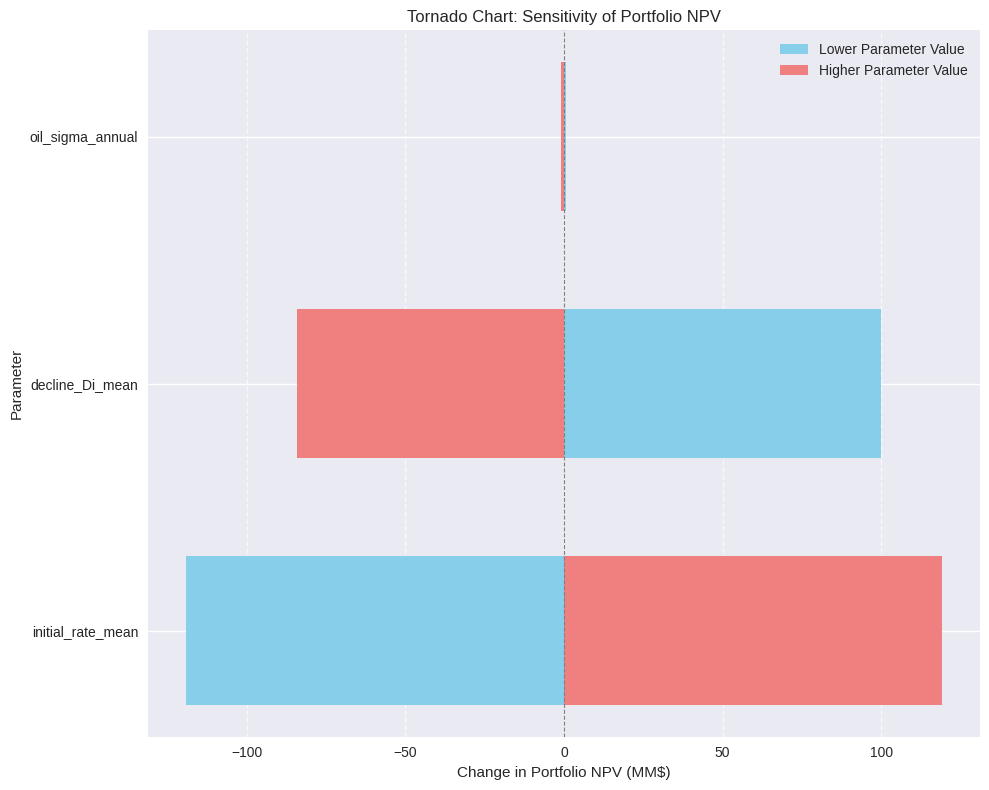

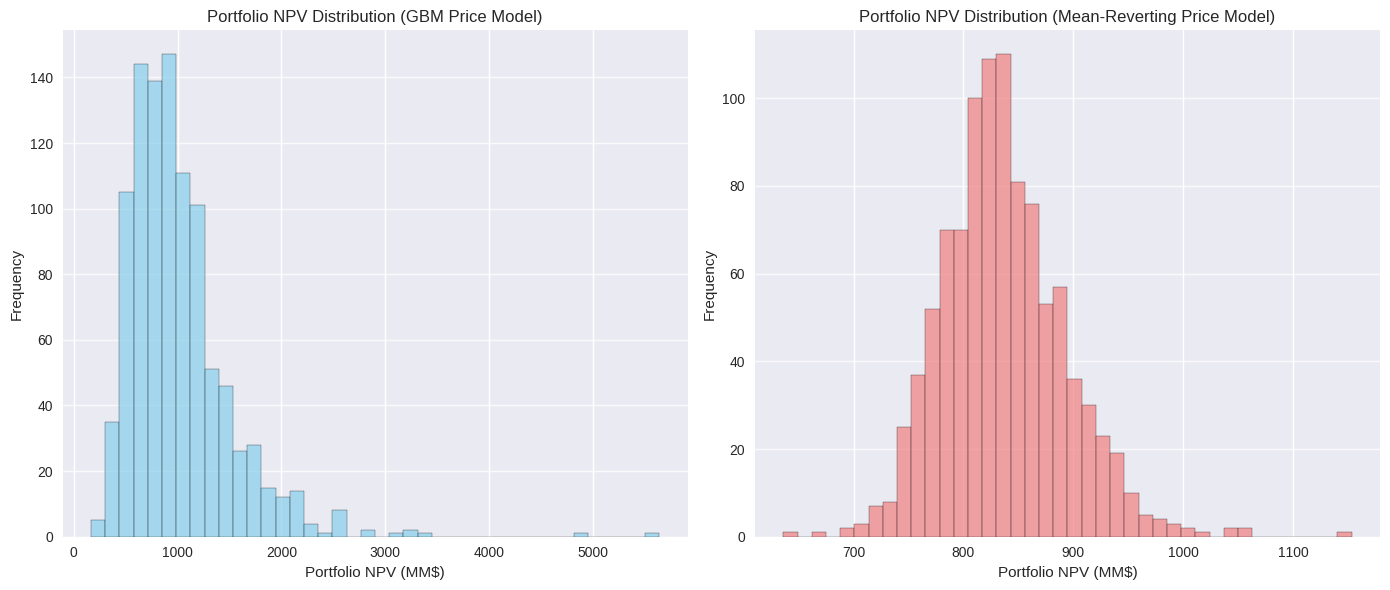

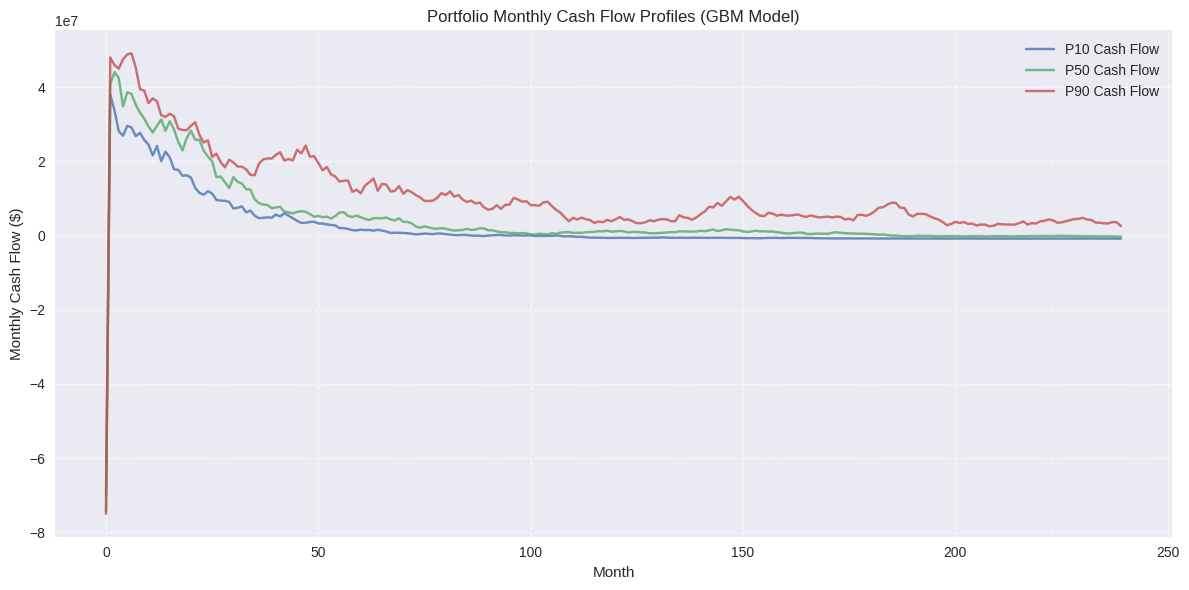

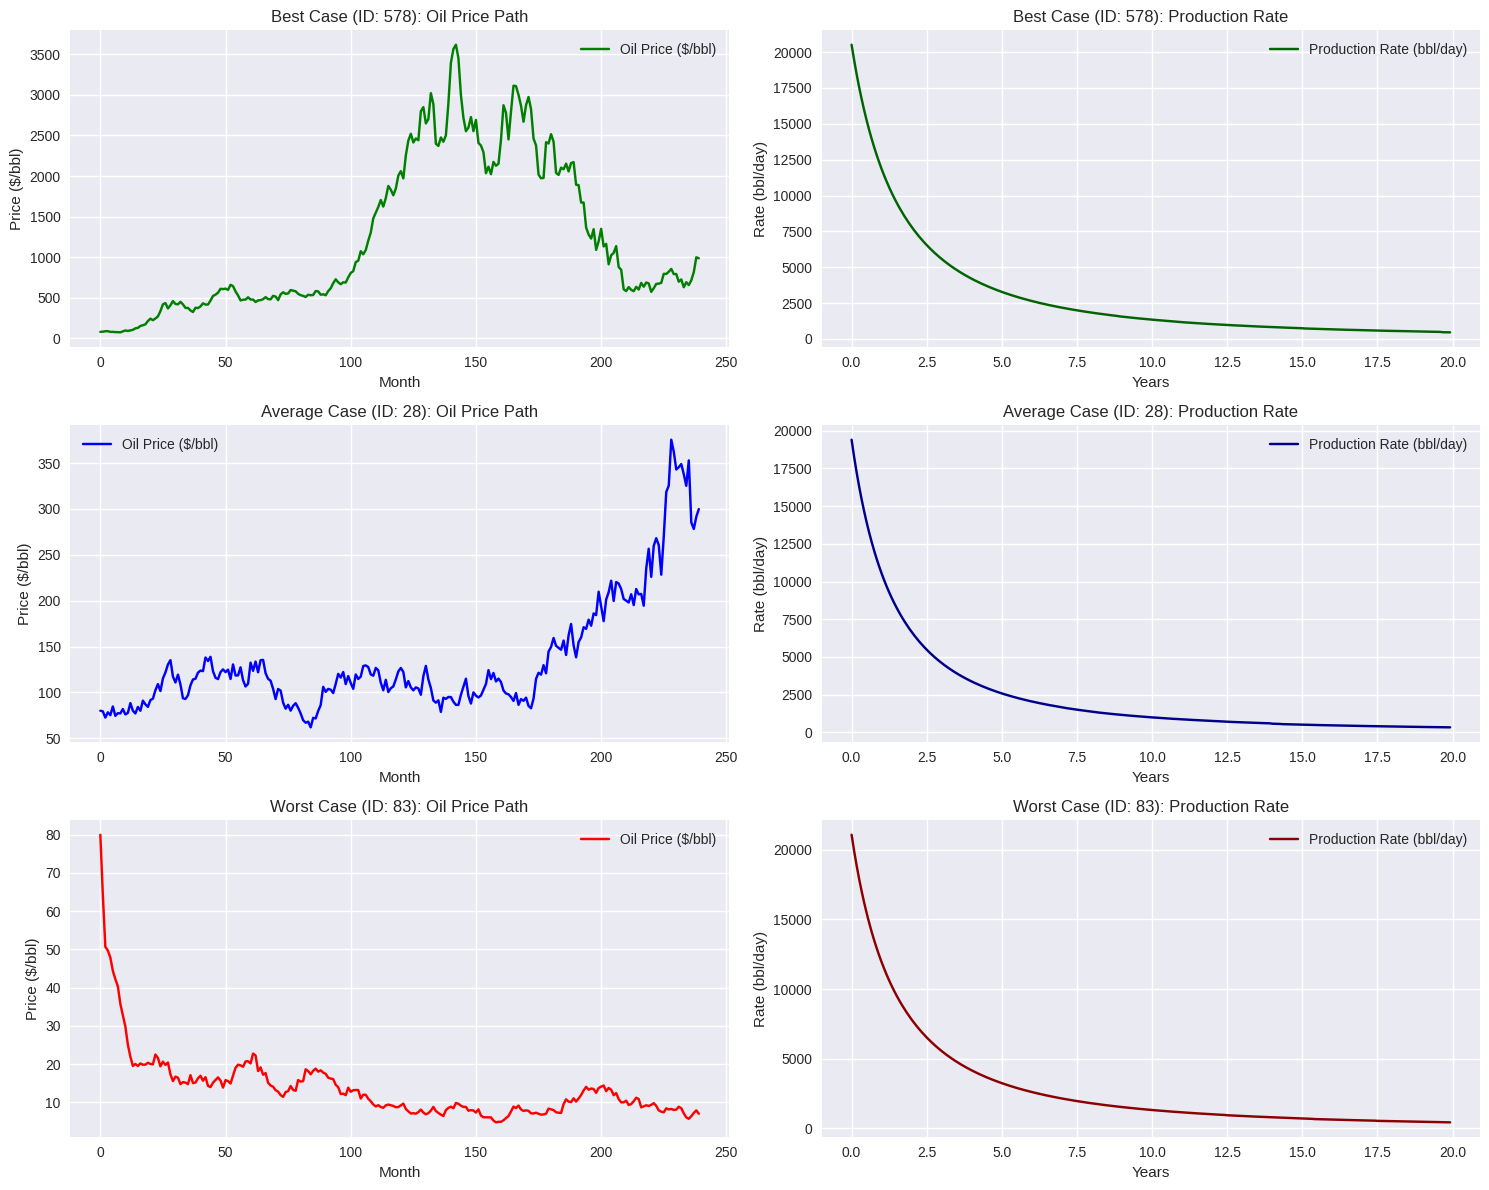

In [63]:
print("\n--- Regenerating Plots ---\n")

# 1. Tornado Chart
plt.figure(figsize=(10, 8))
y_pos = np.arange(len(params))
plt.barh(y_pos, changes_low, color='skyblue', label='Lower Parameter Value', height=0.6)
plt.barh(y_pos, changes_high, color='lightcoral', label='Higher Parameter Value', height=0.6)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.yticks(y_pos, params)
plt.xlabel('Change in Portfolio NPV (MM$)')
plt.ylabel('Parameter')
plt.title('Tornado Chart: Sensitivity of Portfolio NPV')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Price Model Comparison Histograms
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(gbm_scenario_results["portfolio_npv"].values / 1e6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Portfolio NPV (MM$)")
plt.ylabel("Frequency")
plt.title("Portfolio NPV Distribution (GBM Price Model)")
plt.grid(axis='y', alpha=0.75)
plt.subplot(1, 2, 2)
plt.hist(mr_scenario_results["portfolio_npv"].values / 1e6, bins=40, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel("Portfolio NPV (MM$)")
plt.ylabel("Frequency")
plt.title("Portfolio NPV Distribution (Mean-Reverting Price Model)")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# 3. P10, P50, and P90 Cash Flow Profiles
plt.figure(figsize=(12, 6))
months = np.arange(SIM_CONFIG["horizon_months"])
plt.plot(months, p10_cashflow, label='P10 Cash Flow', alpha=0.8)
plt.plot(months, p50_cashflow, label='P50 Cash Flow', alpha=0.8)
plt.plot(months, p90_cashflow, label='P90 Cash Flow', alpha=0.8)
plt.xlabel('Month')
plt.ylabel('Monthly Cash Flow ($)')
plt.title('Portfolio Monthly Cash Flow Profiles (GBM Model)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Representative Price and Production Paths
plt.figure(figsize=(15, 12))
month_indices = np.arange(SIM_CONFIG["horizon_months"])
t_years = month_indices / SIM_CONFIG["months_per_year"]

# Best Case
plt.subplot(3, 2, 1)
plt.plot(month_indices, scenario_data['best']['prices'], label='Oil Price ($/bbl)', color='green')
plt.title(f'Best Case (ID: {best_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t_years, scenario_data['best']['production'], label='Production Rate (bbl/day)', color='darkgreen')
plt.title(f'Best Case (ID: {best_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

# Average Case
plt.subplot(3, 2, 3)
plt.plot(month_indices, scenario_data['average']['prices'], label='Oil Price ($/bbl)', color='blue')
plt.title(f'Average Case (ID: {average_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(t_years, scenario_data['average']['production'], label='Production Rate (bbl/day)', color='darkblue')
plt.title(f'Average Case (ID: {average_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

# Worst Case
plt.subplot(3, 2, 5)
plt.plot(month_indices, scenario_data['worst']['prices'], label='Oil Price ($/bbl)', color='red')
plt.title(f'Worst Case (ID: {worst_npv_scenario_id}): Oil Price Path')
plt.xlabel('Month')
plt.ylabel('Price ($/bbl)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(t_years, scenario_data['worst']['production'], label='Production Rate (bbl/day)', color='darkred')
plt.title(f'Worst Case (ID: {worst_npv_scenario_id}): Production Rate')
plt.xlabel('Years')
plt.ylabel('Rate (bbl/day)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Review all the analyses, summarize the key insights, and discuss the implications for decision-making regarding the oil and gas production portfolio.


## Summary:

### Data Analysis Key Findings

*   **Sensitivity Analysis:** The portfolio's Net Present Value (NPV) is most sensitive to `initial_rate_mean` (total impact of approximately \$238.57 MM) and `decline_Di_mean` (total impact of approximately -\$184.27 MM) for a \(\pm\)10% perturbation. `oil_sigma_annual` has a negligible impact (total impact of -\$1.56 MM).
*   **Price Model Comparison:**
    *   **Geometric Brownian Motion (GBM) Model:** Exhibited a mean NPV of \$981,524,717 with a high standard deviation of \$463,632,058. It showed a wide range of outcomes, with P10 at \$515,070,321 and P90 at \$1,564,212,274, indicating higher potential upside but also significant downside risk (VaR 5% of \$435,372,127, CVaR 5% of \$378,900,673).
    *   **Mean-Reverting Model:** Yielded a lower mean NPV of \$836,176,889 but a substantially reduced standard deviation of \$55,594,718. The NPV distribution was much tighter, with P10 at \$769,713,903 and P90 at \$908,231,963, reflecting lower volatility and more predictable outcomes (VaR 5% of \$754,283,155, CVaR 5% of \$734,404,186).
*   **Cash Flow Profiles:** The P10, P50, and P90 NPVs for the portfolio under the GBM model were calculated at \$540,025,133, \$913,975,298, and \$1,634,456,636, respectively. Representative monthly cash flow profiles for these scenarios were successfully identified and plotted.
*   **Break-Even Analysis:**
    *   **Individual Wells:** The break-even oil prices for individual wells ranged from approximately \$10.85/bbl to \$41.92/bbl, indicating varied economic viability across the portfolio.
    *   **Entire Portfolio:** The calculated break-even oil price for the entire portfolio is \$18.36/bbl, meaning the portfolio becomes profitable above this price under deterministic assumptions.
*   **Reinforcement Learning Agent (Random):** A random RL agent, interacting with the newly designed environment, demonstrated a wide range of episode NPVs, from \$339,232,115 to \$1,200,759,699 across 5 episodes. This variability underscores the impact of drilling decisions and capital allocation strategies on portfolio value.

### Insights or Next Steps

*   **Risk Management & Price Model Choice:** Given the significant difference in NPV distribution and risk metrics between GBM and Mean-Reverting price models, it is crucial to select the price model that best reflects the company's long-term outlook and risk appetite for commodity price forecasts. GBM is suitable for higher risk/reward scenarios, while Mean-Reverting is better for stable, long-term price expectations. Decision-makers should evaluate the implications of each model for capital allocation and investment thresholds.
*   **Portfolio Optimization with RL:** The foundational RL environment and agent are in place. The next step is to implement more sophisticated RL algorithms (e.g., Q-learning, Deep Q-Networks, Policy Gradient methods) to train an agent to learn optimal drilling sequencing and capital allocation strategies. This can lead to maximizing portfolio NPV under uncertainty, going beyond static well prioritization.
